# Procesos Gaussianos {#sec-GPs}

In [1]:
#| code-fold: true

import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import preliz as pz
from scipy.special import expit as logistic
np.set_printoptions(precision=3)
az.style.use("arviz-doc")

## Objetivos

* Funciones como objetos probabilistas
* Kernels
* Procesos Gaussianos con likelihoods Gaussianos
* Procesos Gaussianos con likelihoods no-gaussianos
* Procesos Gaussianos en espacios de Hilbert

## Representando funciones como objetos estocásticos

Comenzaremos nuestro análisis de los procesos gaussianos describiendo primero una forma de representar funciones como objetos probabilísticos. Podemos pensar en una función $f$ como un mapeo desde un conjunto de entradas $X$ a un conjunto de salidas $Y$:

$$
Y = f(X)
$$

For ejemplo, podríamos tener la  la función $f(x) = sin(x)$, donde $X$ es el conjunto de todos los números reales e $Y$ es el conjunto de todos los números reales entre -1 y 1. Si evaluamos la función en una cantidad finita de puntos, podemos representar la función como una tabla de valores.

In [2]:
x0 = np.linspace(0, 2 * np.pi, 10)
np.stack([x0, np.sin(x0)]).T

array([[ 0.000e+00,  0.000e+00],
       [ 6.981e-01,  6.428e-01],
       [ 1.396e+00,  9.848e-01],
       [ 2.094e+00,  8.660e-01],
       [ 2.793e+00,  3.420e-01],
       [ 3.491e+00, -3.420e-01],
       [ 4.189e+00, -8.660e-01],
       [ 4.887e+00, -9.848e-01],
       [ 5.585e+00, -6.428e-01],
       [ 6.283e+00, -2.449e-16]])

De forma similar al graficar una función solo evaluamos la función en unos pocos puntos, pero los sistemas de gráficos como matplotlib y similares interpolan los valores intermedios lo que nos permite obtener una representación de la función que parece "suave".


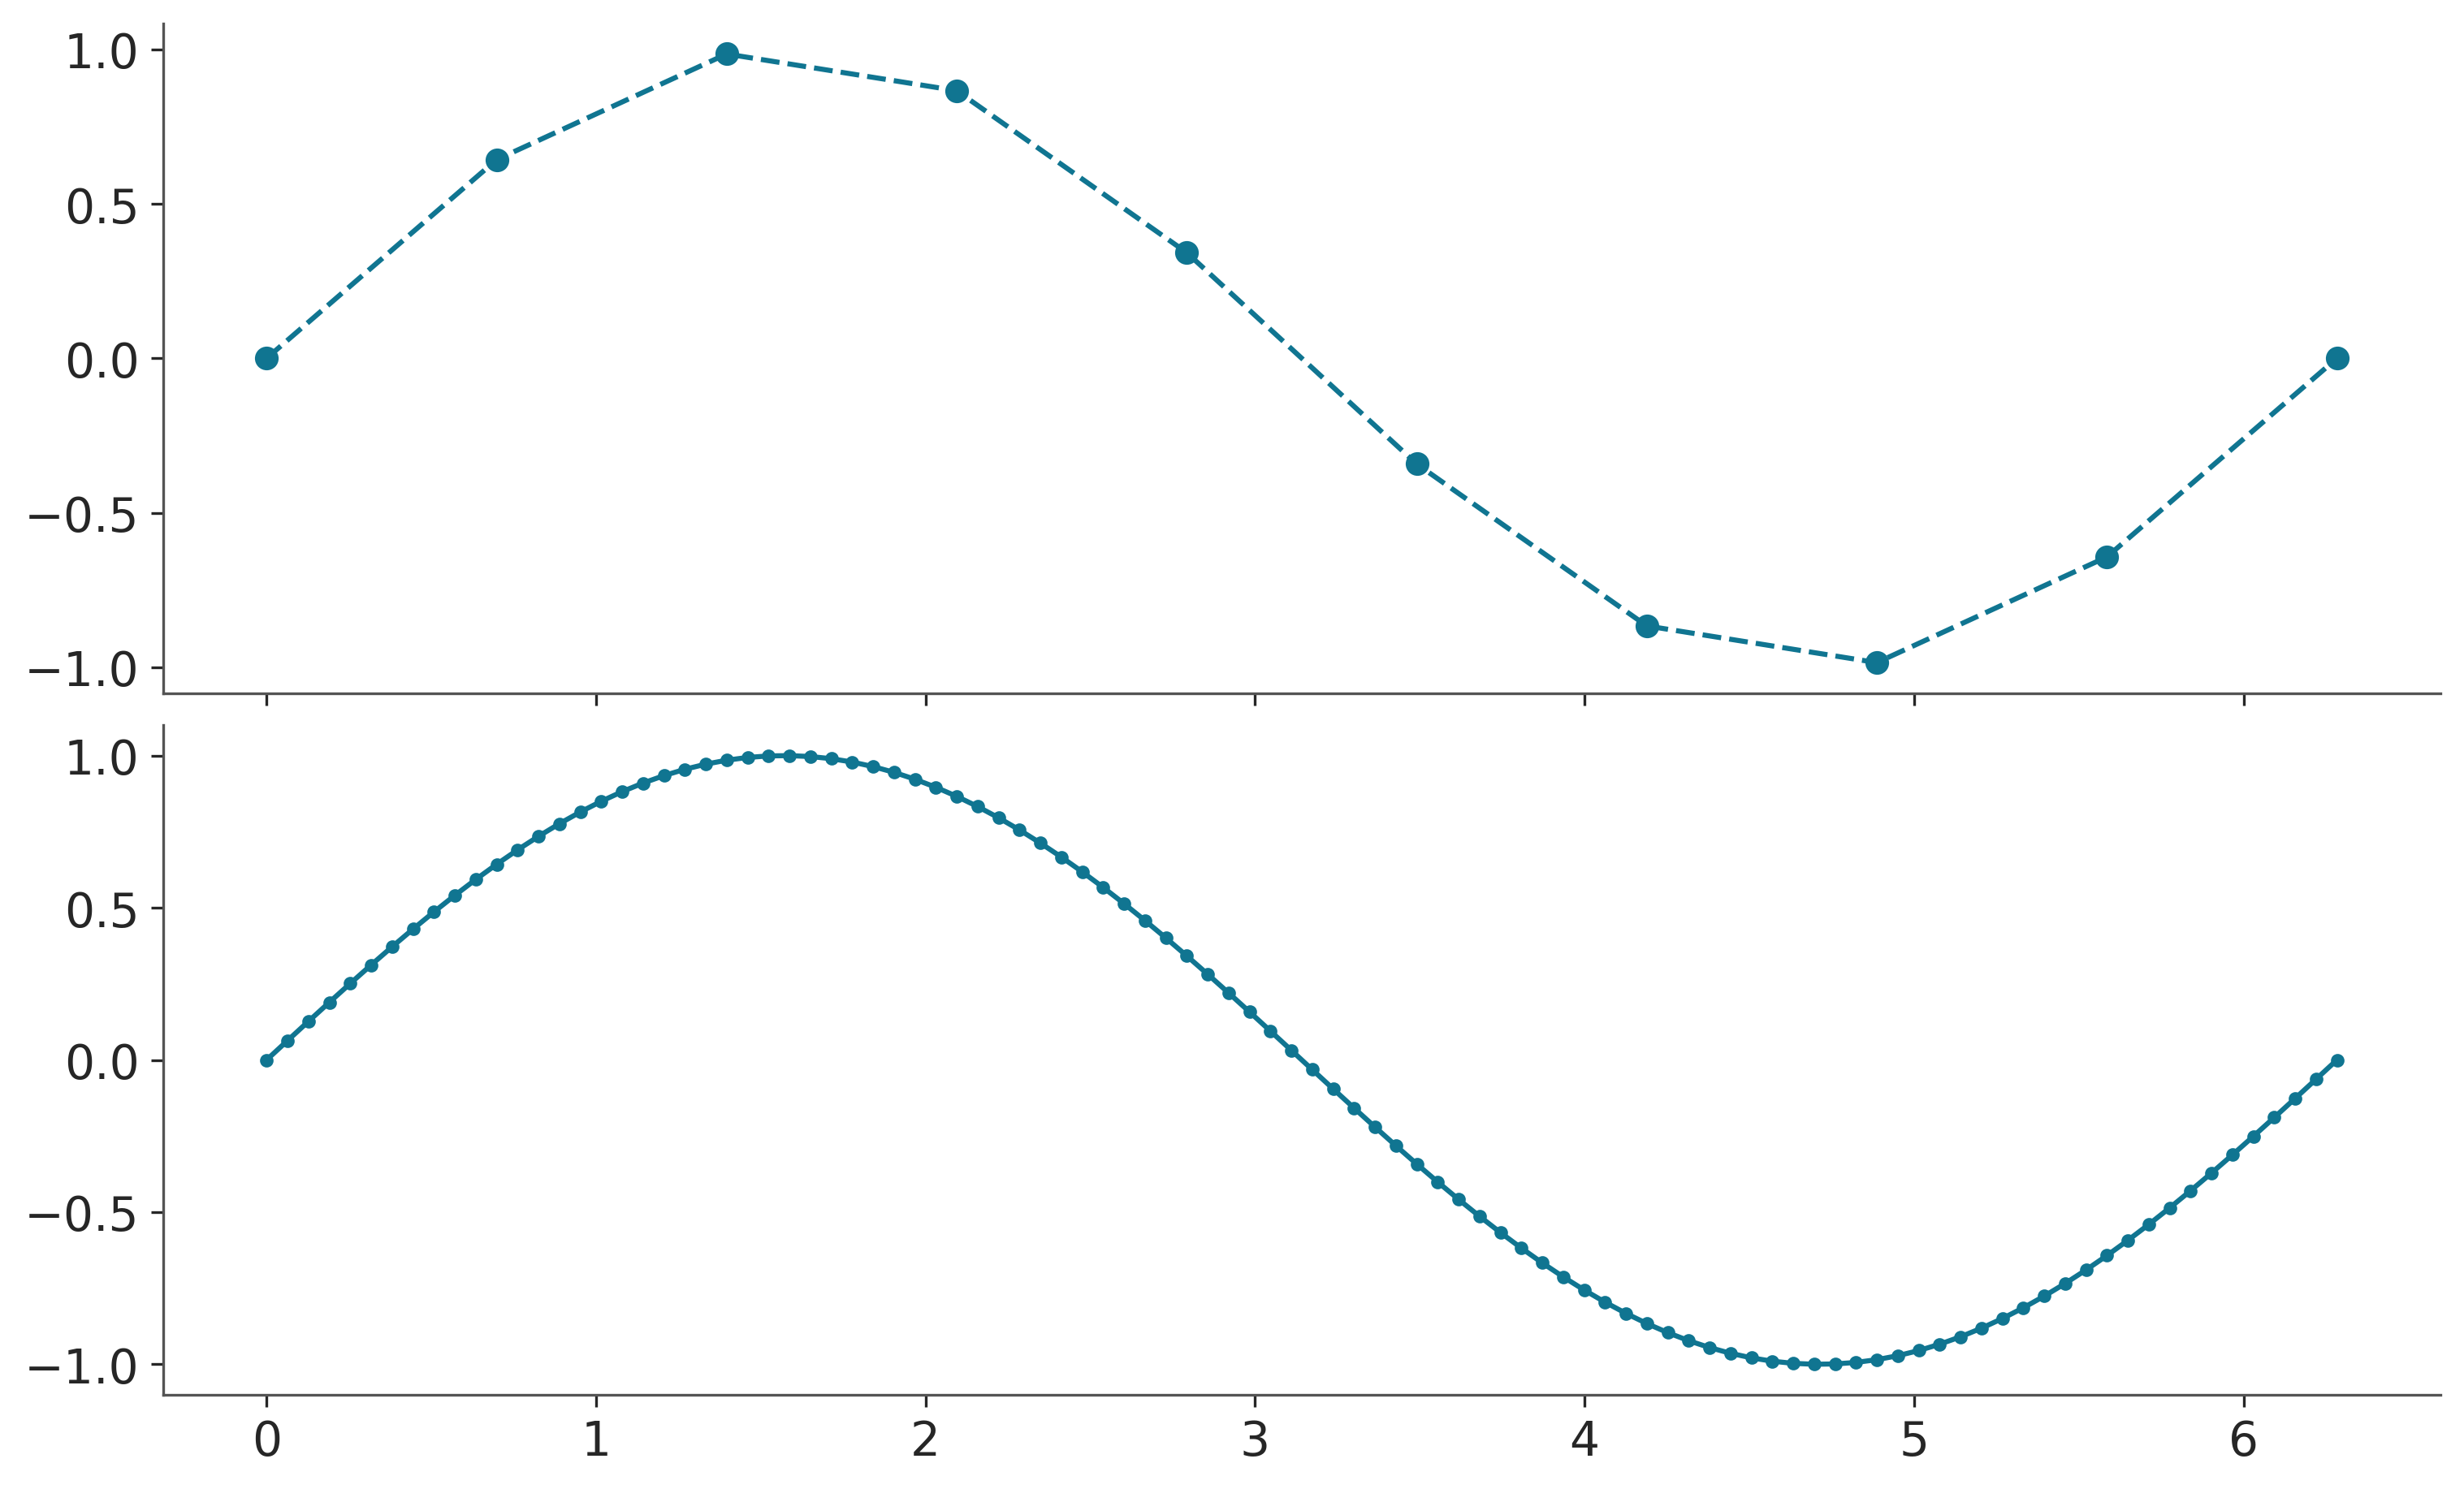

In [3]:
x1 = np.linspace(0, 2 * np.pi, 100)
_, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
ax[0].plot(x0, np.sin(x0), "o--", color="C0")
ax[1].plot(x1, np.sin(x1), ".-", color="C0");

Con estos ejemplos simplemente quiero hacer evidente que muchas veces aproximamos/representamos funciones como una lista ordenada de valores $(X_i, Y_i)$. En principio la lista debería ser infinita, pero por cuestiones prácticas siempre será finita. 

Hasta ahora nada nuevo. La novedad es como generalizar esta idea para representar funciones probabilísticamente. Una forma de hacer esto es considerar que cada valor $Y_i$ es una variable aleatoria con una distribución asociada. Por simplicidad, vamos a asumir que la distribución asociada es Gaussiana. Las Gaussianas son conceptualmente fáciles de entender y posen varias propiedades matemáticas que hace simple trabajar con ellas, o al menos más simple que otras alternativas.

El siguiente bloque de código muestra esta idea en práctica con dos variantes:

* La primer "función" la conseguimos asociando una distribución Normal(0, 1) de forma independiente. Es decir, para cada valor de $X_i$ le asociamos un valor $Y_i$ que es una variable aleatoria independiente con distribución Normal(0, 1).

* En el segundo caso el valor de $Y_i$ depende del valor de $Y_{i-1}$. Es decir, estamos generando una función con más "estructura" en el sentido que los valores de $Y_i$ están correlacionados con los valores de $Y_{i-1}$.


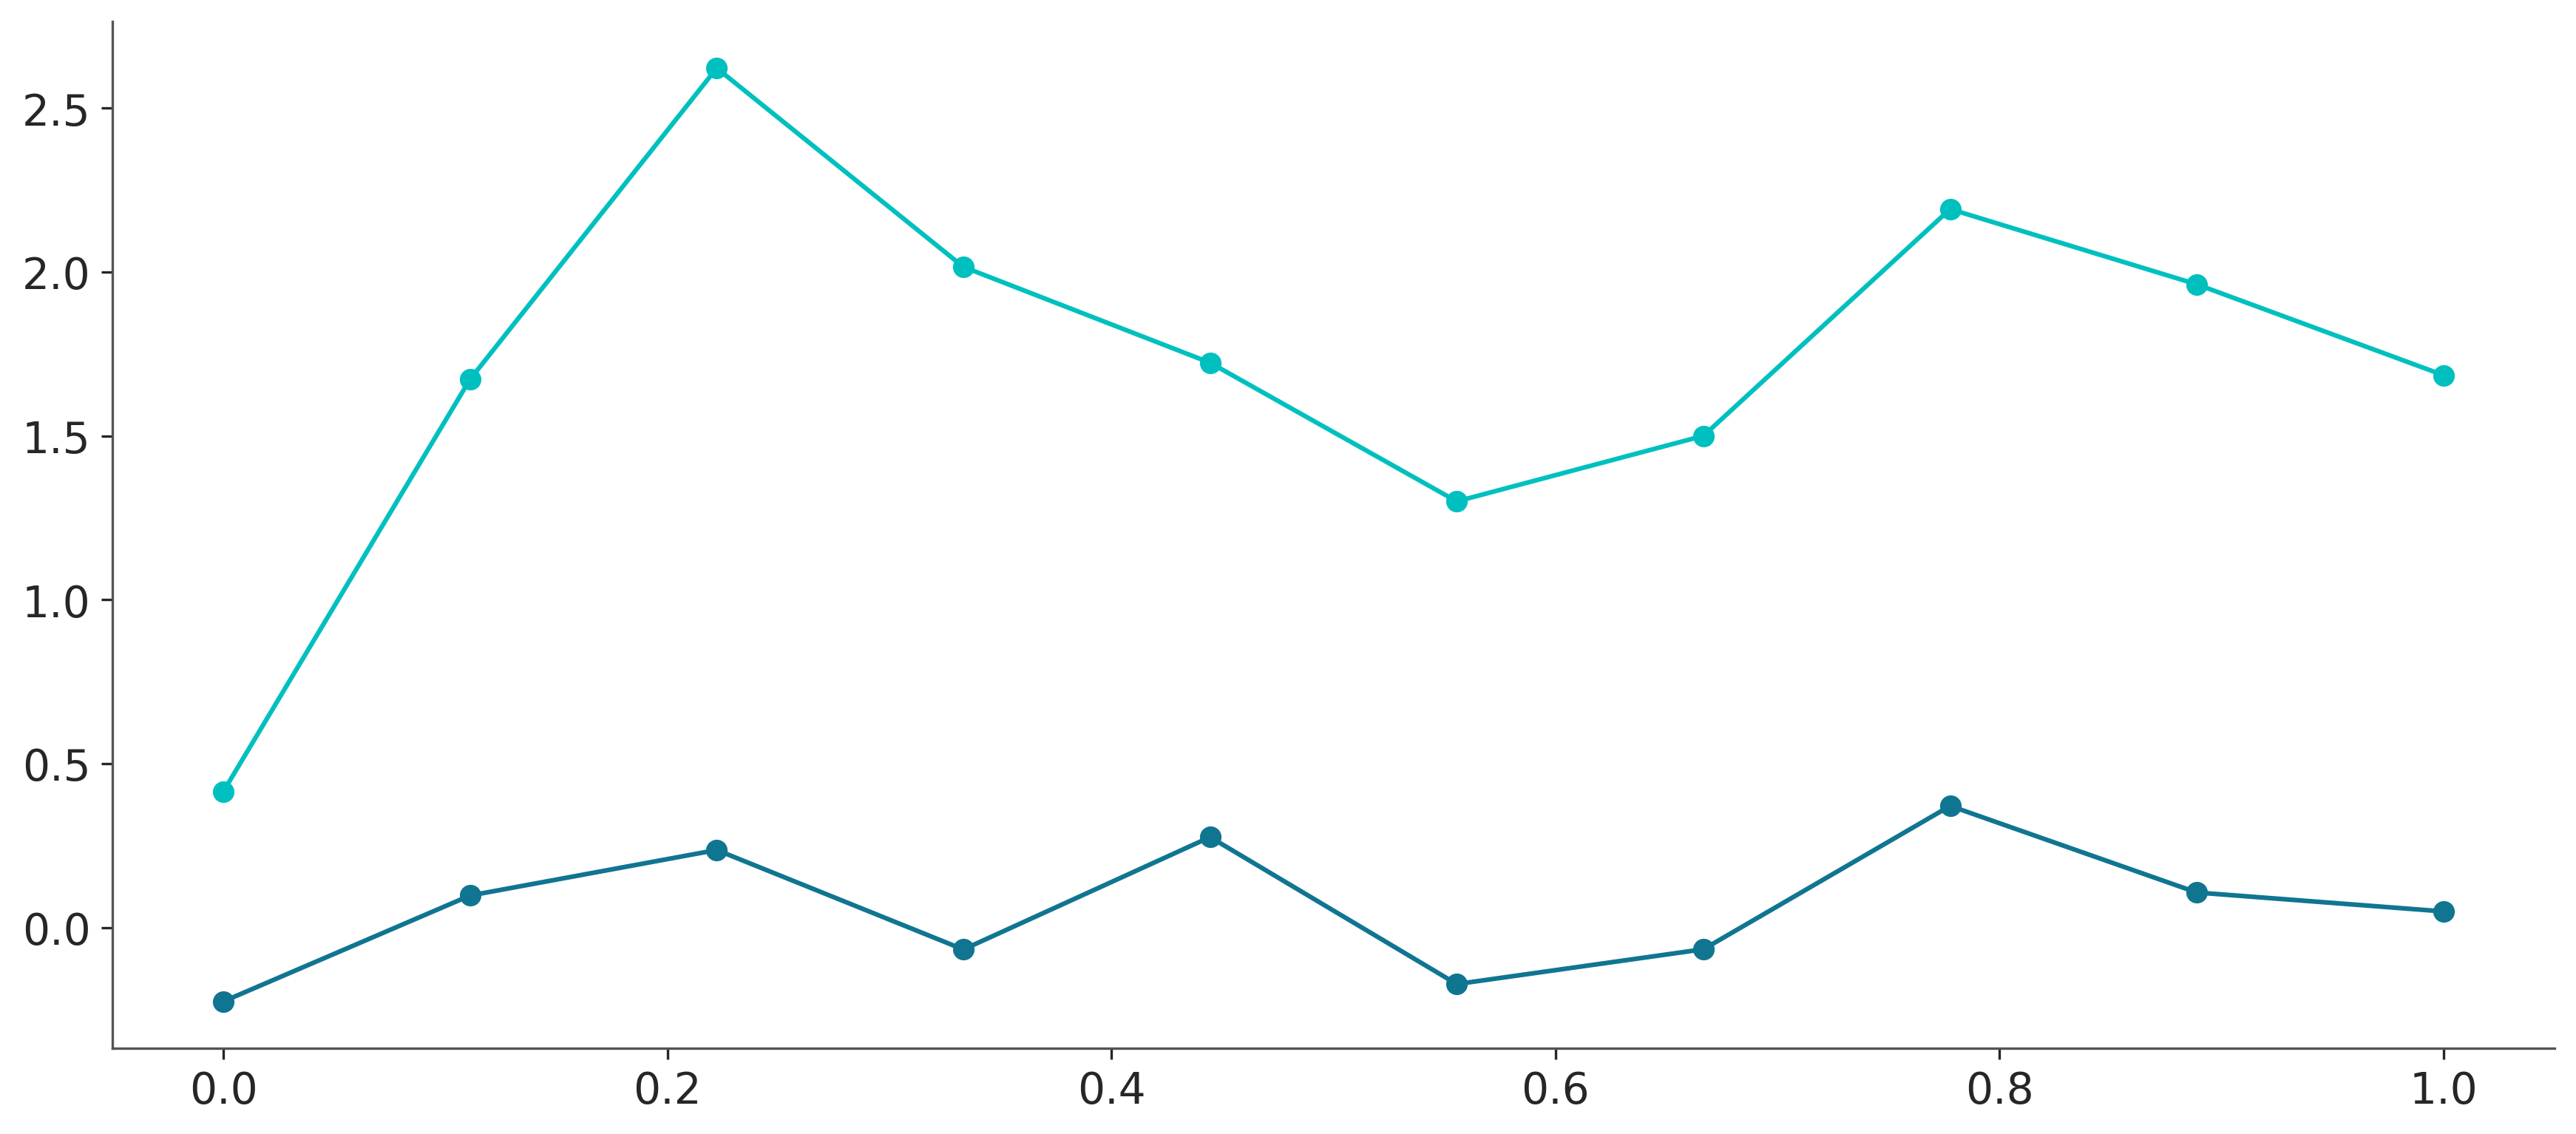

In [4]:
np.random.seed(237)
x = np.linspace(0, 1, 10)
y = pz.Normal(0, 0.2).rvs(len(x), random_state=237)
plt.plot(x, y, 'o-')
y = np.zeros_like(x)

for i in range(len(x)):
    y[i] = np.random.normal(y[i-1], 0.5)

plt.plot(x, y, 'o-');

En este punto conviene detenerse y notar que si continuáramos generando "funciones" de esta forma podríamos obtener una aproximación a la función seno, a varias lineas rectas con distinta pendiente, y también a otras funciones. Es decir el procedimiento es lo suficientemente flexible para representar varias funciones, al menos de forma aproximada. Los resultados concretos dependerán de los parámetros que tome cada distribución normal (y también de los valores de `x`).

De todas formas este procedimiento parece un poco rudimentario como para ser útil en la práctica. Sería útil pensar en algún mecanismo que permita tener mayor control sobre el tipo de funciones que se pueden generar y que permita codificar de forma más simple relaciones entre puntos de la función. Por ejemplo es común que las funciones varíen de forma suave, es decir esperamos que para dos valores similares de $X_i$ obtengamos valores similares de $Y_i$.

Una vía razonable para alcanzar este objetivo es reemplazar el uso de $n$ gaussianas univariadas por una sola Gaussiana multivariada de dimensión $n$. Una Gaussiana multivariada se define por una vector media y una matriz de covarianza. La matriz de covarianza representa la relación entre las diferentes variables aleatorias. Por ejemplo, si la matriz de covarianza es diagonal, entonces las variables aleatorias son independientes. 

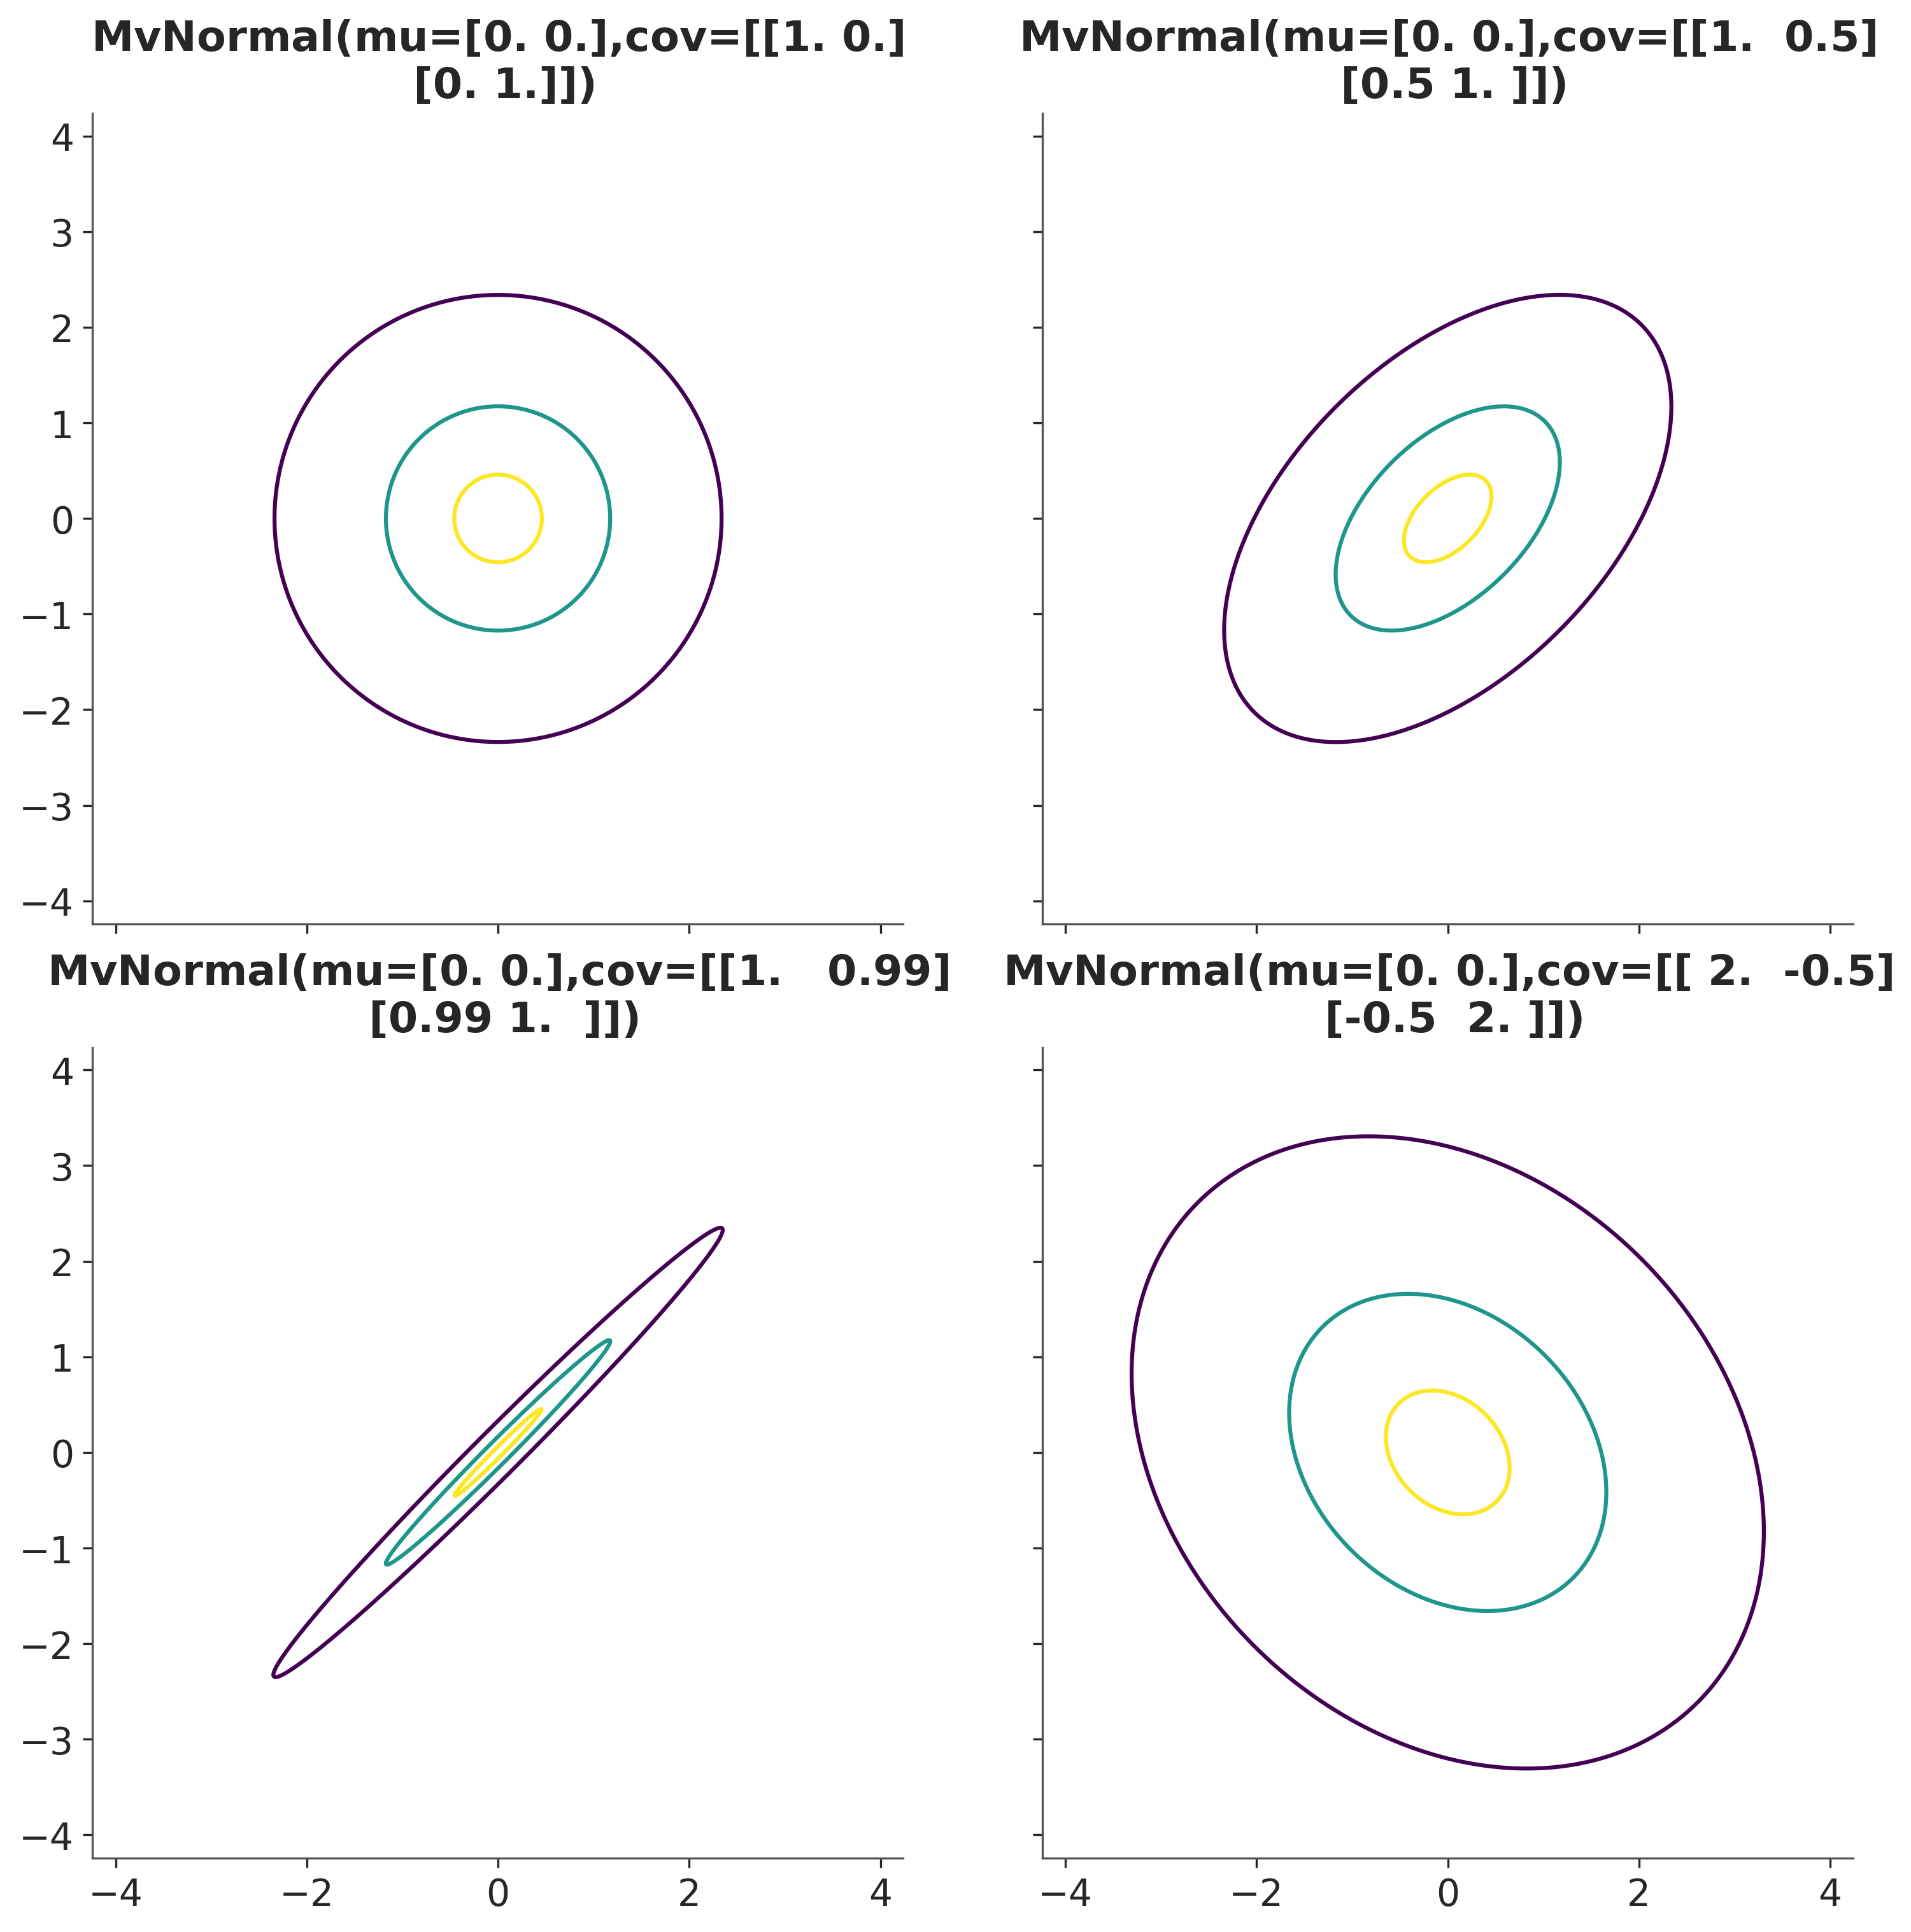

In [5]:
#| code-fold: true

_, axes = plt.subplots(2,2, figsize=(10, 10), sharex=True, sharey=True)

for cov, ax in zip([[[1, 0], [0, 1]], 
                    [[1, 0.5], [0.5, 1]], 
                    [[1, 0.99], [0.99, 1]], 
                    [[2, -0.5], [-0.5, 2]]], axes.ravel()):
    pz.MvNormal([0, 0], cov).plot_pdf(marginals=False, ax=ax)

En el caso de las funciones, la matriz de covarianza codifica la relación entre los valores de la función evaluada en diferentes puntos. Como se muestra en la siguiente figura para una gaussiana bivariada. Desde esta perspectiva muestrear puntos de la Gaussiana multivariada es equivalente a muestrear una función. Podemos ver que la dimensionalidad de la Gaussiana multivariada es igual a la cantidad de puntos que queremos usar para muestrear de la función (o punto a representar).


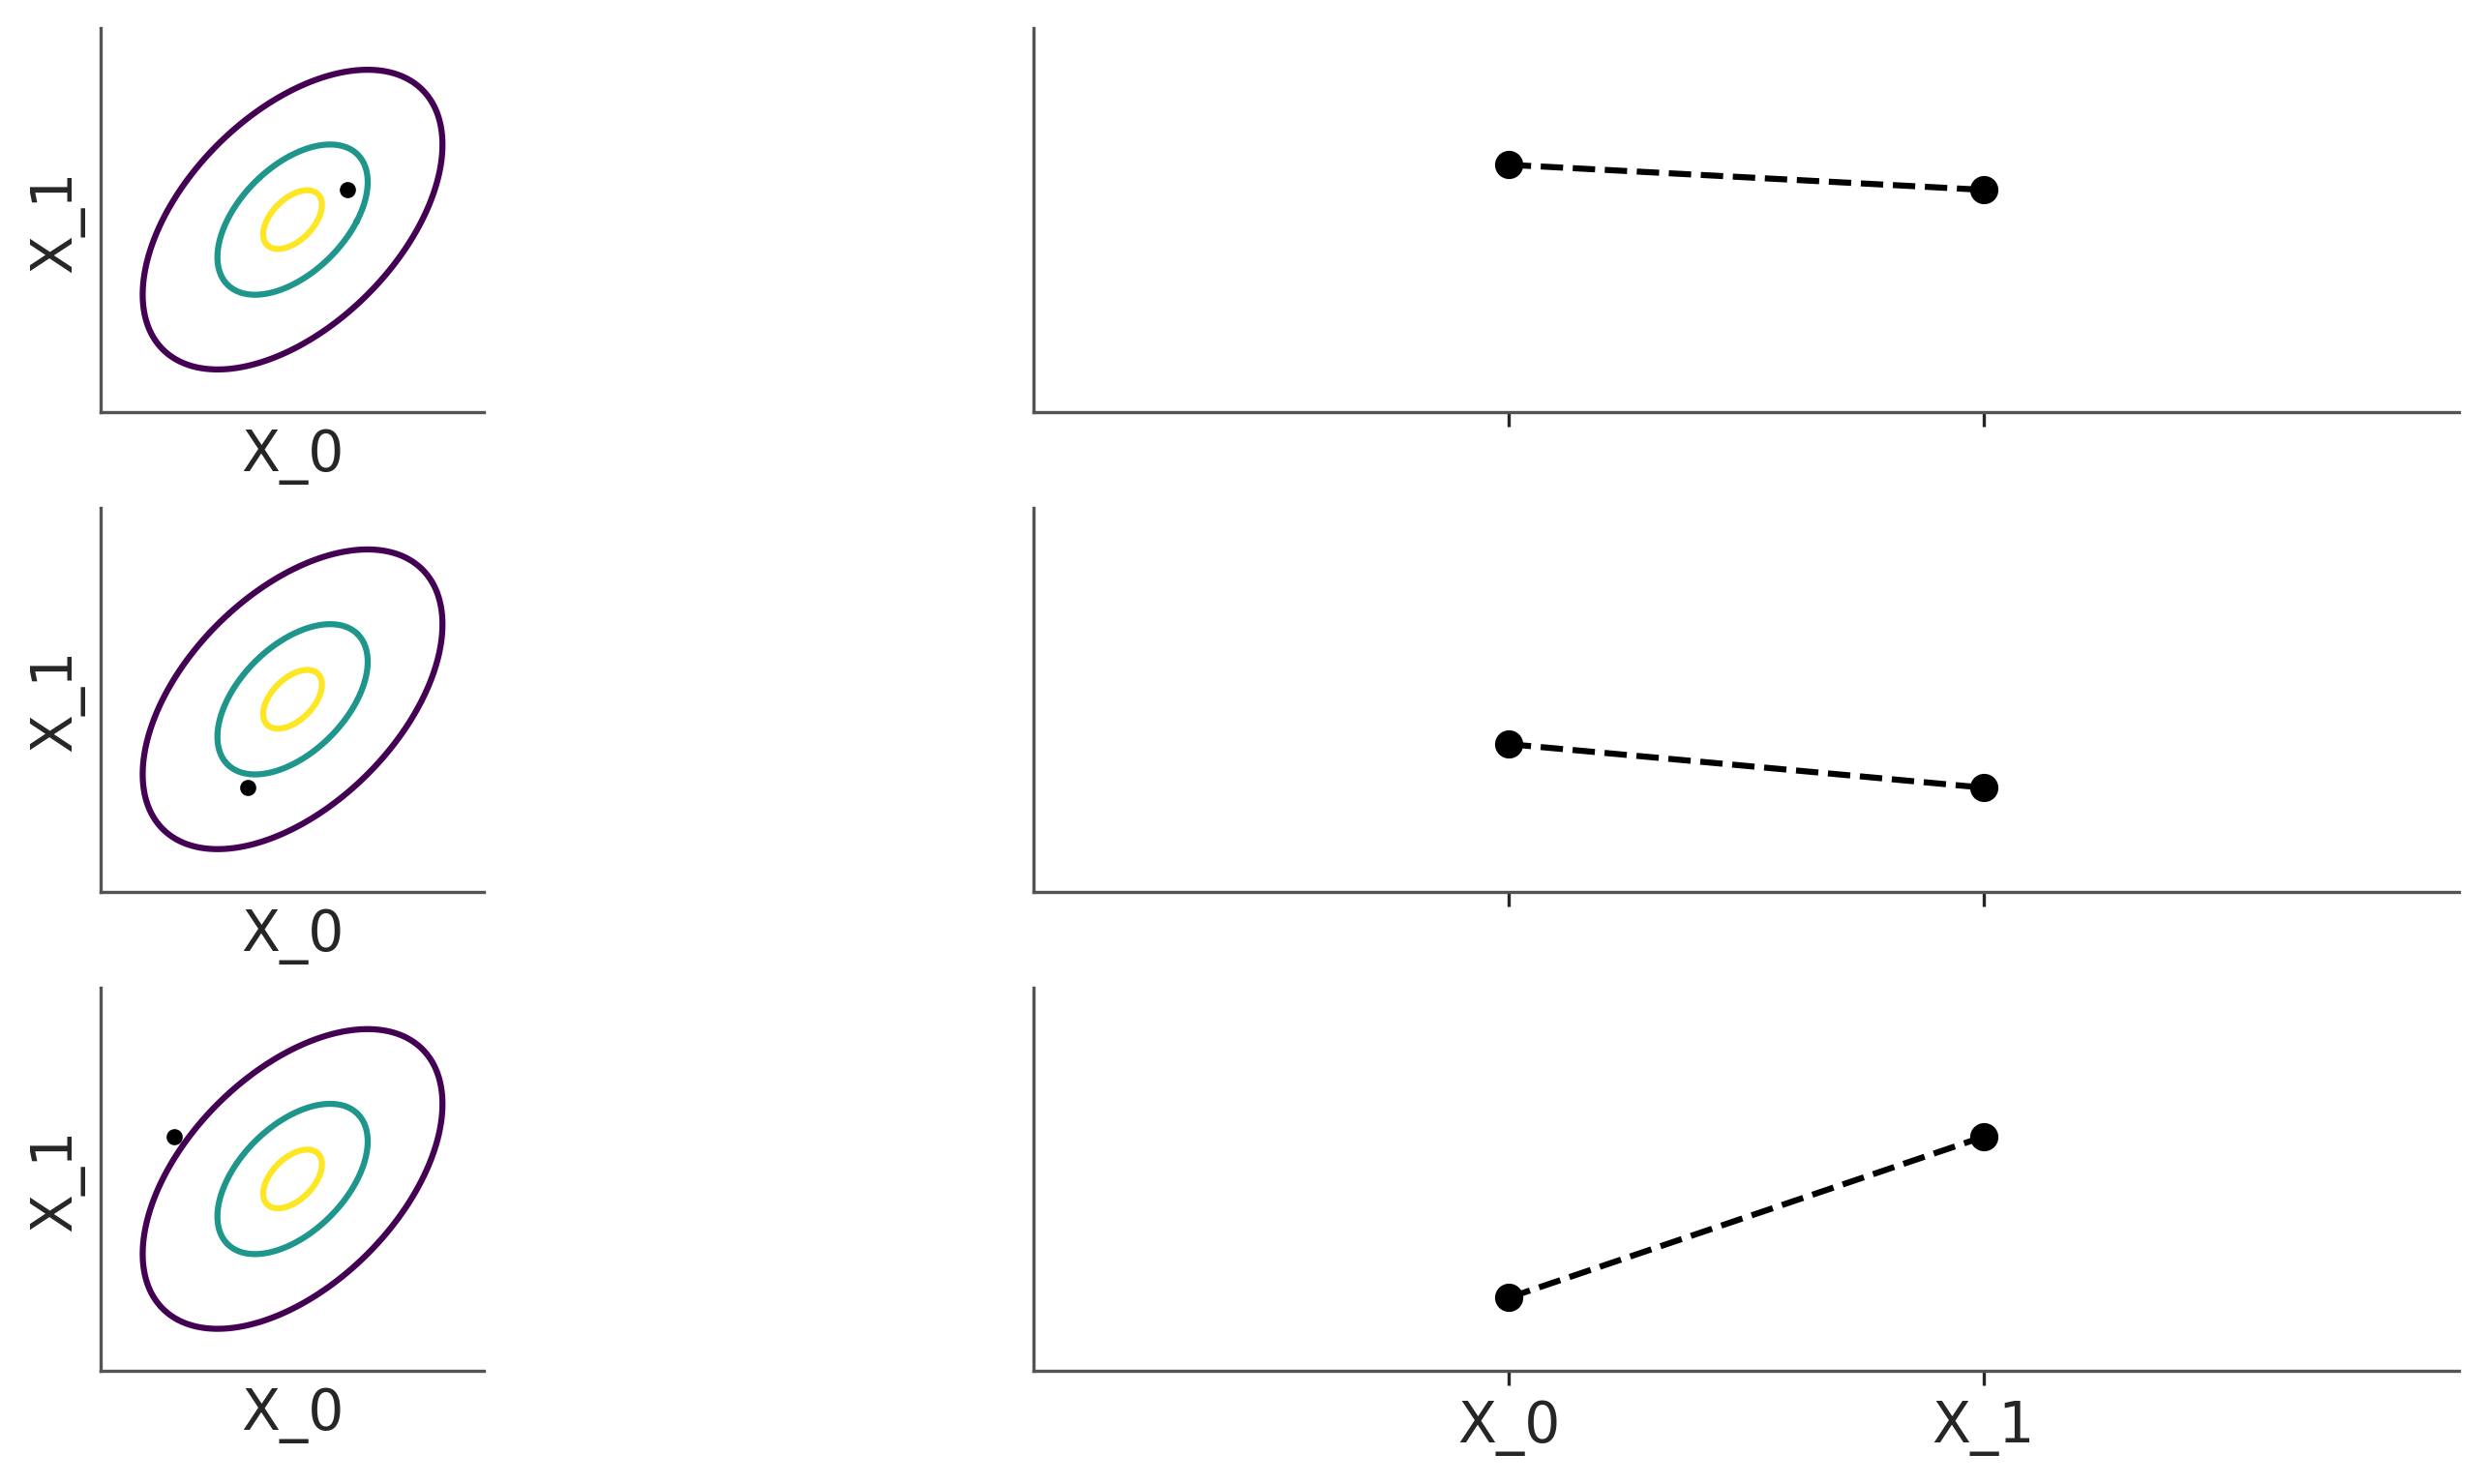

In [6]:
#| code-fold: true

_, axes = plt.subplots(3,2, figsize=(10, 5), sharex="col", sharey=True)
dist = pz.MvNormal([0, 0], [[1, 0.5], [0.5, 1]])
vals = dist.rvs(3, random_state=239)
for idx, v in enumerate(vals):
    dist.plot_pdf(marginals=False, ax=axes[idx,0])
    axes[idx,0].set_title("")
    axes[idx,0].plot(*v, "k.")
    axes[idx, 1].plot([-1, 1], v, "ko--")
    axes[idx, 1].set_xticks([-1, 1], ["X_0", "X_1"])
    axes[idx, 1].set_xlim(-3, 3)
    axes[idx, 1].set_yticks([])
    axes[idx, 0].set_xticks([])
    axes[idx, 0].set_xlabel("X_0")
    axes[idx, 0].set_ylabel("X_1")
   

## Procesos Gaussianos

Hasta ahora hemos venido hablando de funciones como objetos probabilísticos desde una perspectiva que parece un poco artificial, casi como un truco. Hicimos este recorrido, a fin de generar intuición. Sin embargo, es posible formalizar de forma rigurosa la representación de funciones como objetos probabilísticos. Para ello necesitamos introducir el concepto de proceso estocástico. 

> Un proceso estocástico es una colección de variables aleatorias indexadas por un conjunto de índices. Asi como una muestra de una distribución unidimensional es un número, una muestra (o realización) de un proceso estocástico es una función. Por ello a los procesos estocásticos se los suele llamar función aleatoria. 

Es común que los índices representen tiempo, pero esto no es necesario. En los ejemplos anteriores los indices vienen dados por lo valores de $X_i$ y las variables aleatorias son los valores de $Y_i$. Estos indices funcionan de forma similar a los indices en "listas" o "vectores" en programación, con la diferencia que en este caso los indices son reales y no enteros. 

Existen muchos tipos de procesos estocásticos, uno de ellos se llama Proceso Gaussiano (GP). 

> Un proceso gaussiano es un proceso estocástico tal que cualquier subconjunto finito de variables aleatorias tiene una distribución Gaussiana. 

En otras palabras, un proceso gaussiano es _como_ una Gaussiana multivariada de dimensión infinita, pero que si la evaluamos en cualquier conjunto finito de valores obtenemos una Gaussiana multivariada de dimensión finita. Esta propiedad es sumamente útil, por que matemáticamente y conceptualmente estamos trabajando con un objeto infinito (como lo es la función seno, por ej), pero si marginalizamos sobre todos los puntos NO observados obtenemos una Gaussiana multivariada definida por los puntos observados!

El principal interés de los GPs en estadística Bayesiana, es que podemos pensarlos con una distribución sobre funciones. 

Un GP, se define estrictamente por un vector media infinito y una matriz de covarianza infinita, pero como ya mencionamos, en la práctica siempre trabajamos en un espacio finito. Por lo que vector media y la matriz de covarianza son finitos. En la práctica es común trabajar con un vector media cero, por lo que el GP queda definido de forma completa por la matriz de covarianza. 

### Kernels

En la práctica, las matrices de covarianza se especifican mediante funciones conocidas como kernels. Lamentablemente, el término kernel es muy polisémico, incluso en la literatura estadística. Para simplificar llamaremos, y cuando estemos hablando de GPs, llamaremos kernel a cualquier función que devuelva una matriz de covarianza válida.


Hay muchos kernels útiles, uno popular es el kernel cuadrático exponencial:

$$
\kappa(\mathbf{X}, \mathbf{X'}) = \exp\left(-\frac{\|\mathbf{X} - \mathbf{X'}\|^2}{2\ell^2}\right)
$$

Aquí, $\|\mathbf{X} - \mathbf{X'}\|^2$ es la distancia euclidea al cuadrado:

$$
\|\mathbf{X} - \mathbf{X'}\|^2 = (X_1 - X'_1)^2 + (X_2 - X'_2)^2 + \dots + (X_n -X'_n)^2
$$

Para este kernel, podemos ver que tenemos una función simétrica que toma dos entradas y devuelve un valor de 0 si las entradas son iguales, o positivo en caso contrario. Y así podemos interpretar la salida del kernel cuadrático exponenciado como una medida de similitud entre las dos entradas.

Puede que no sea obvio a primera vista, pero el kernel cuadrático exponencial tiene una fórmula similar a la distribución Gaussiana. Por esta razón, este kernel también se llama kernel Gaussiano. El término $\ell$ se conoce como la longitud de escala (o ancho de banda o varianza) y controla el "ancho" del kernel. En otras palabras, controla a qué escala los valores $X$ se consideran similares.

Para comprender mejor el papel de los kernels juguemos un poco. En el siguiente bloque de código definimos un kernel cuadrático exponencial y luego lo evaluamos en 3 puntos `A`, `B` y `C`, que toman los valores `-1, 0.7, 1.5`.

In [7]:
def exp_quad_kernel(x, xi, ℓ=1):
    """kernel cuadrático exponencial"""
    return np.array([np.exp(-(x-x_i)**2 / (2*ℓ**2)) for x_i in xi])


labels = ["A", "B", "C"]
datos = np.array([-1, 0.7, 1.5])
cov = exp_quad_kernel(datos, datos, 1)

La siguiente figura muestra, a la izquierda, los tres puntos y a la derecha la matriz de covarianza generada a partir del kernel. Podemos ver que mientras más similares los datos, más cercana a 1 la correspondiente entrada en la matriz, y mientras más dicímiles más cercana a 0. Cuanto es "similar" es controlado por el parámetro $\ell$.

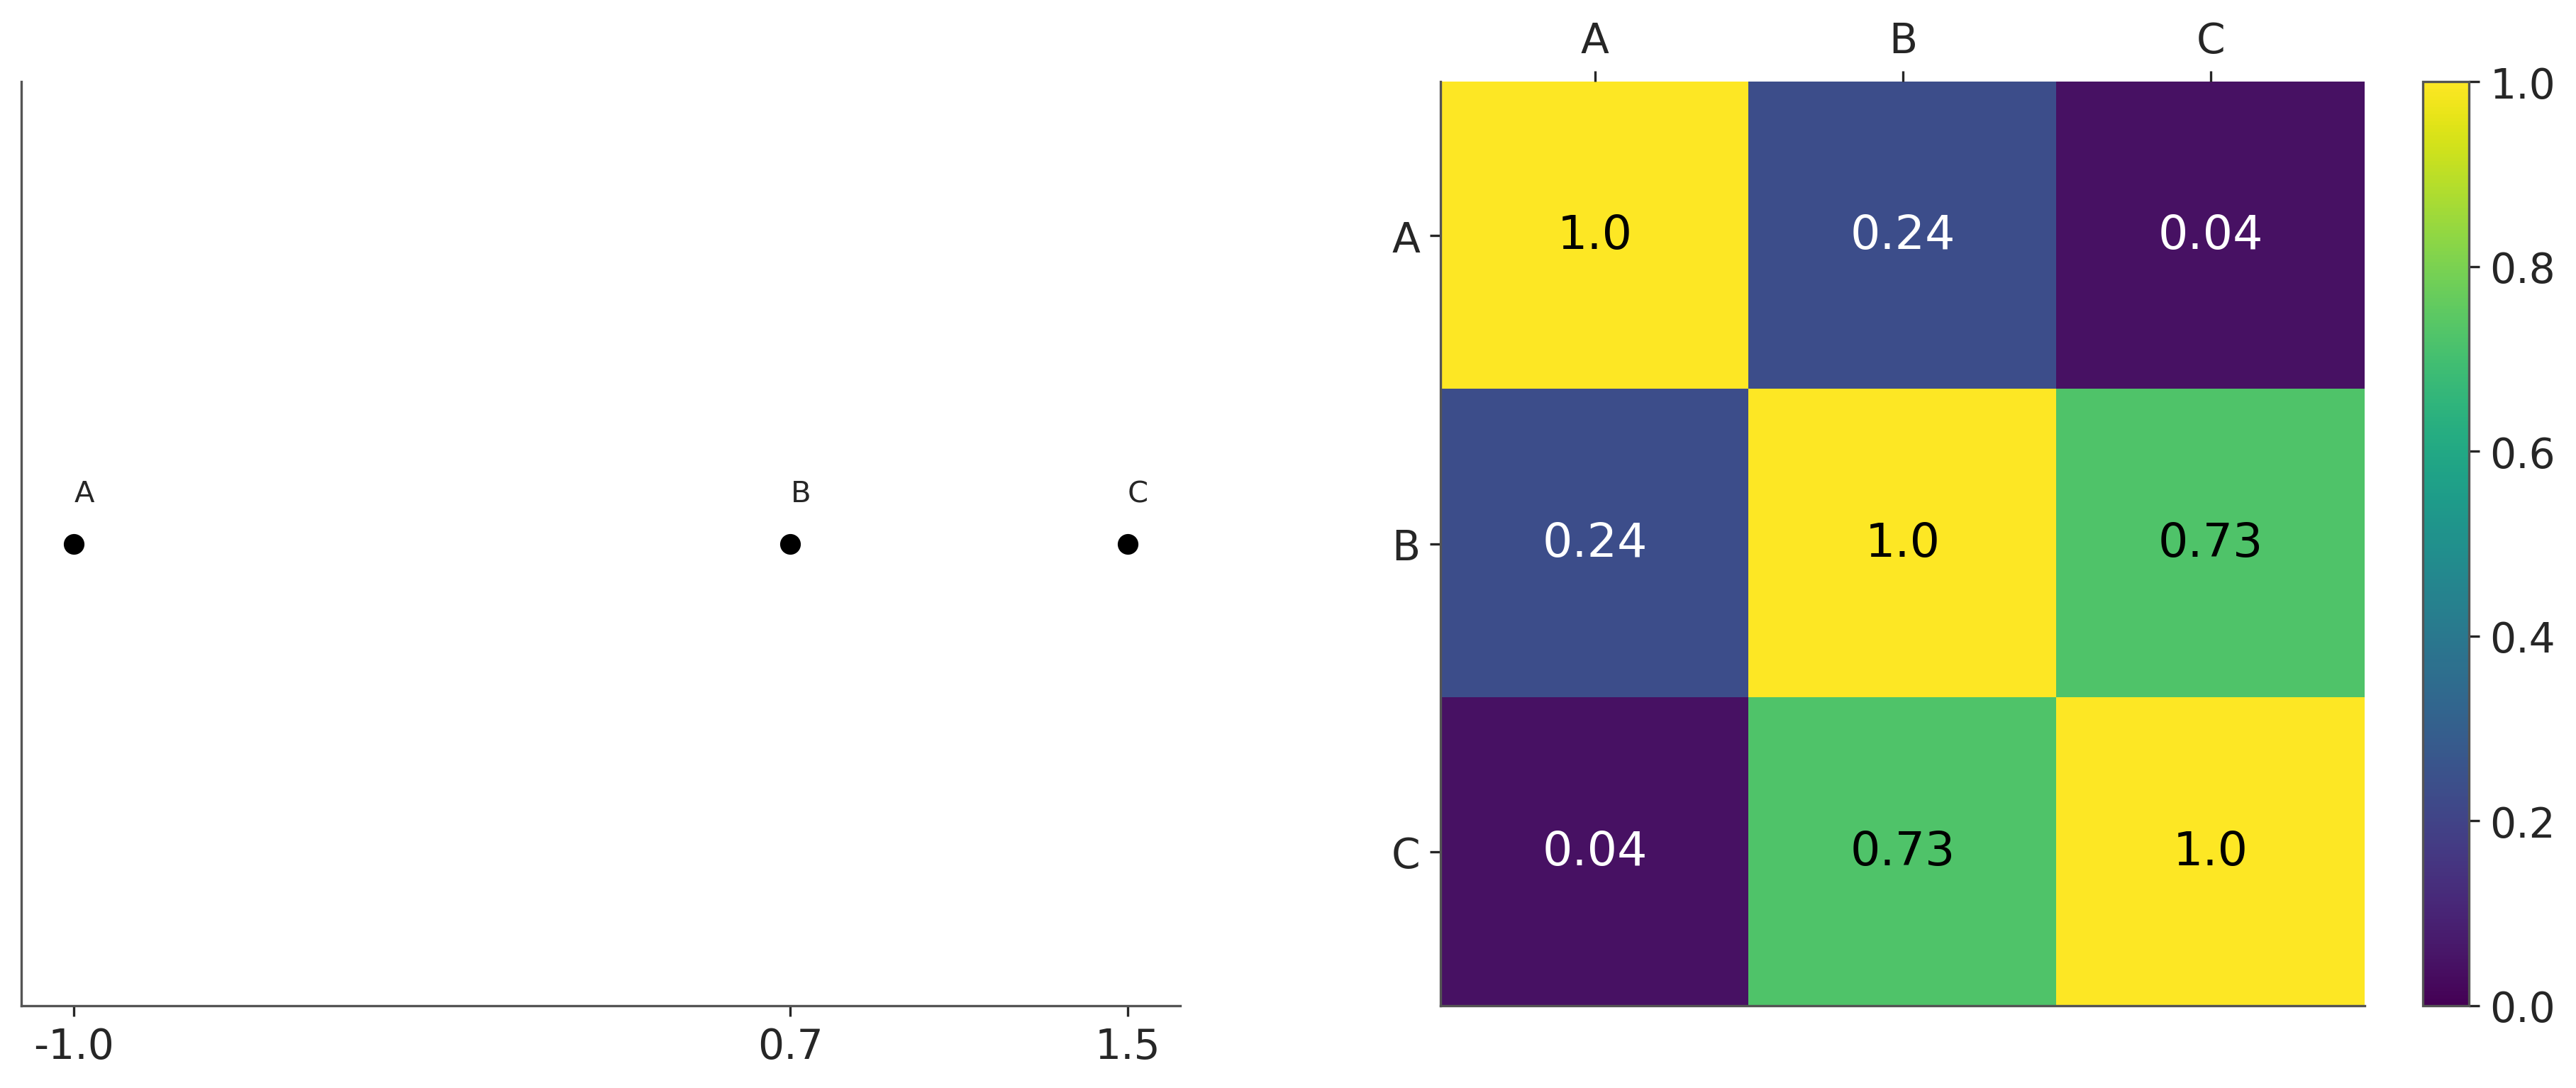

In [8]:
#| code-fold: true
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax = np.ravel(ax)

ax[0].plot(datos, np.zeros_like(datos), 'ko')
ax[0].set_yticks([])
for i, l in zip(datos, labels):
    ax[0].text(i, 0+0.005, l)
ax[0].set_xticks(datos)
ax[0].set_xticklabels(np.round(datos, 2))

ax[1].grid(False)
im = ax[1].imshow(cov, vmin=0, vmax=1)
colors = ['w', 'k']
for i in range(len(cov)):
    for j in range(len(cov)):
        ax[1].text(j, i, round(cov[i, j], 2),
                   color=colors[int(im.norm(cov[i, j]) > 0.5)],
                   ha='center', va='center', fontdict={'size': 16})
ax[1].set_xticks(range(len(datos)), labels)
ax[1].set_yticks(range(len(datos)), labels)
ax[1].xaxis.tick_top()
fig.colorbar(im, ax=ax[1]);

La siguiente figura muestra algunos kernels y las matrices resultantes.

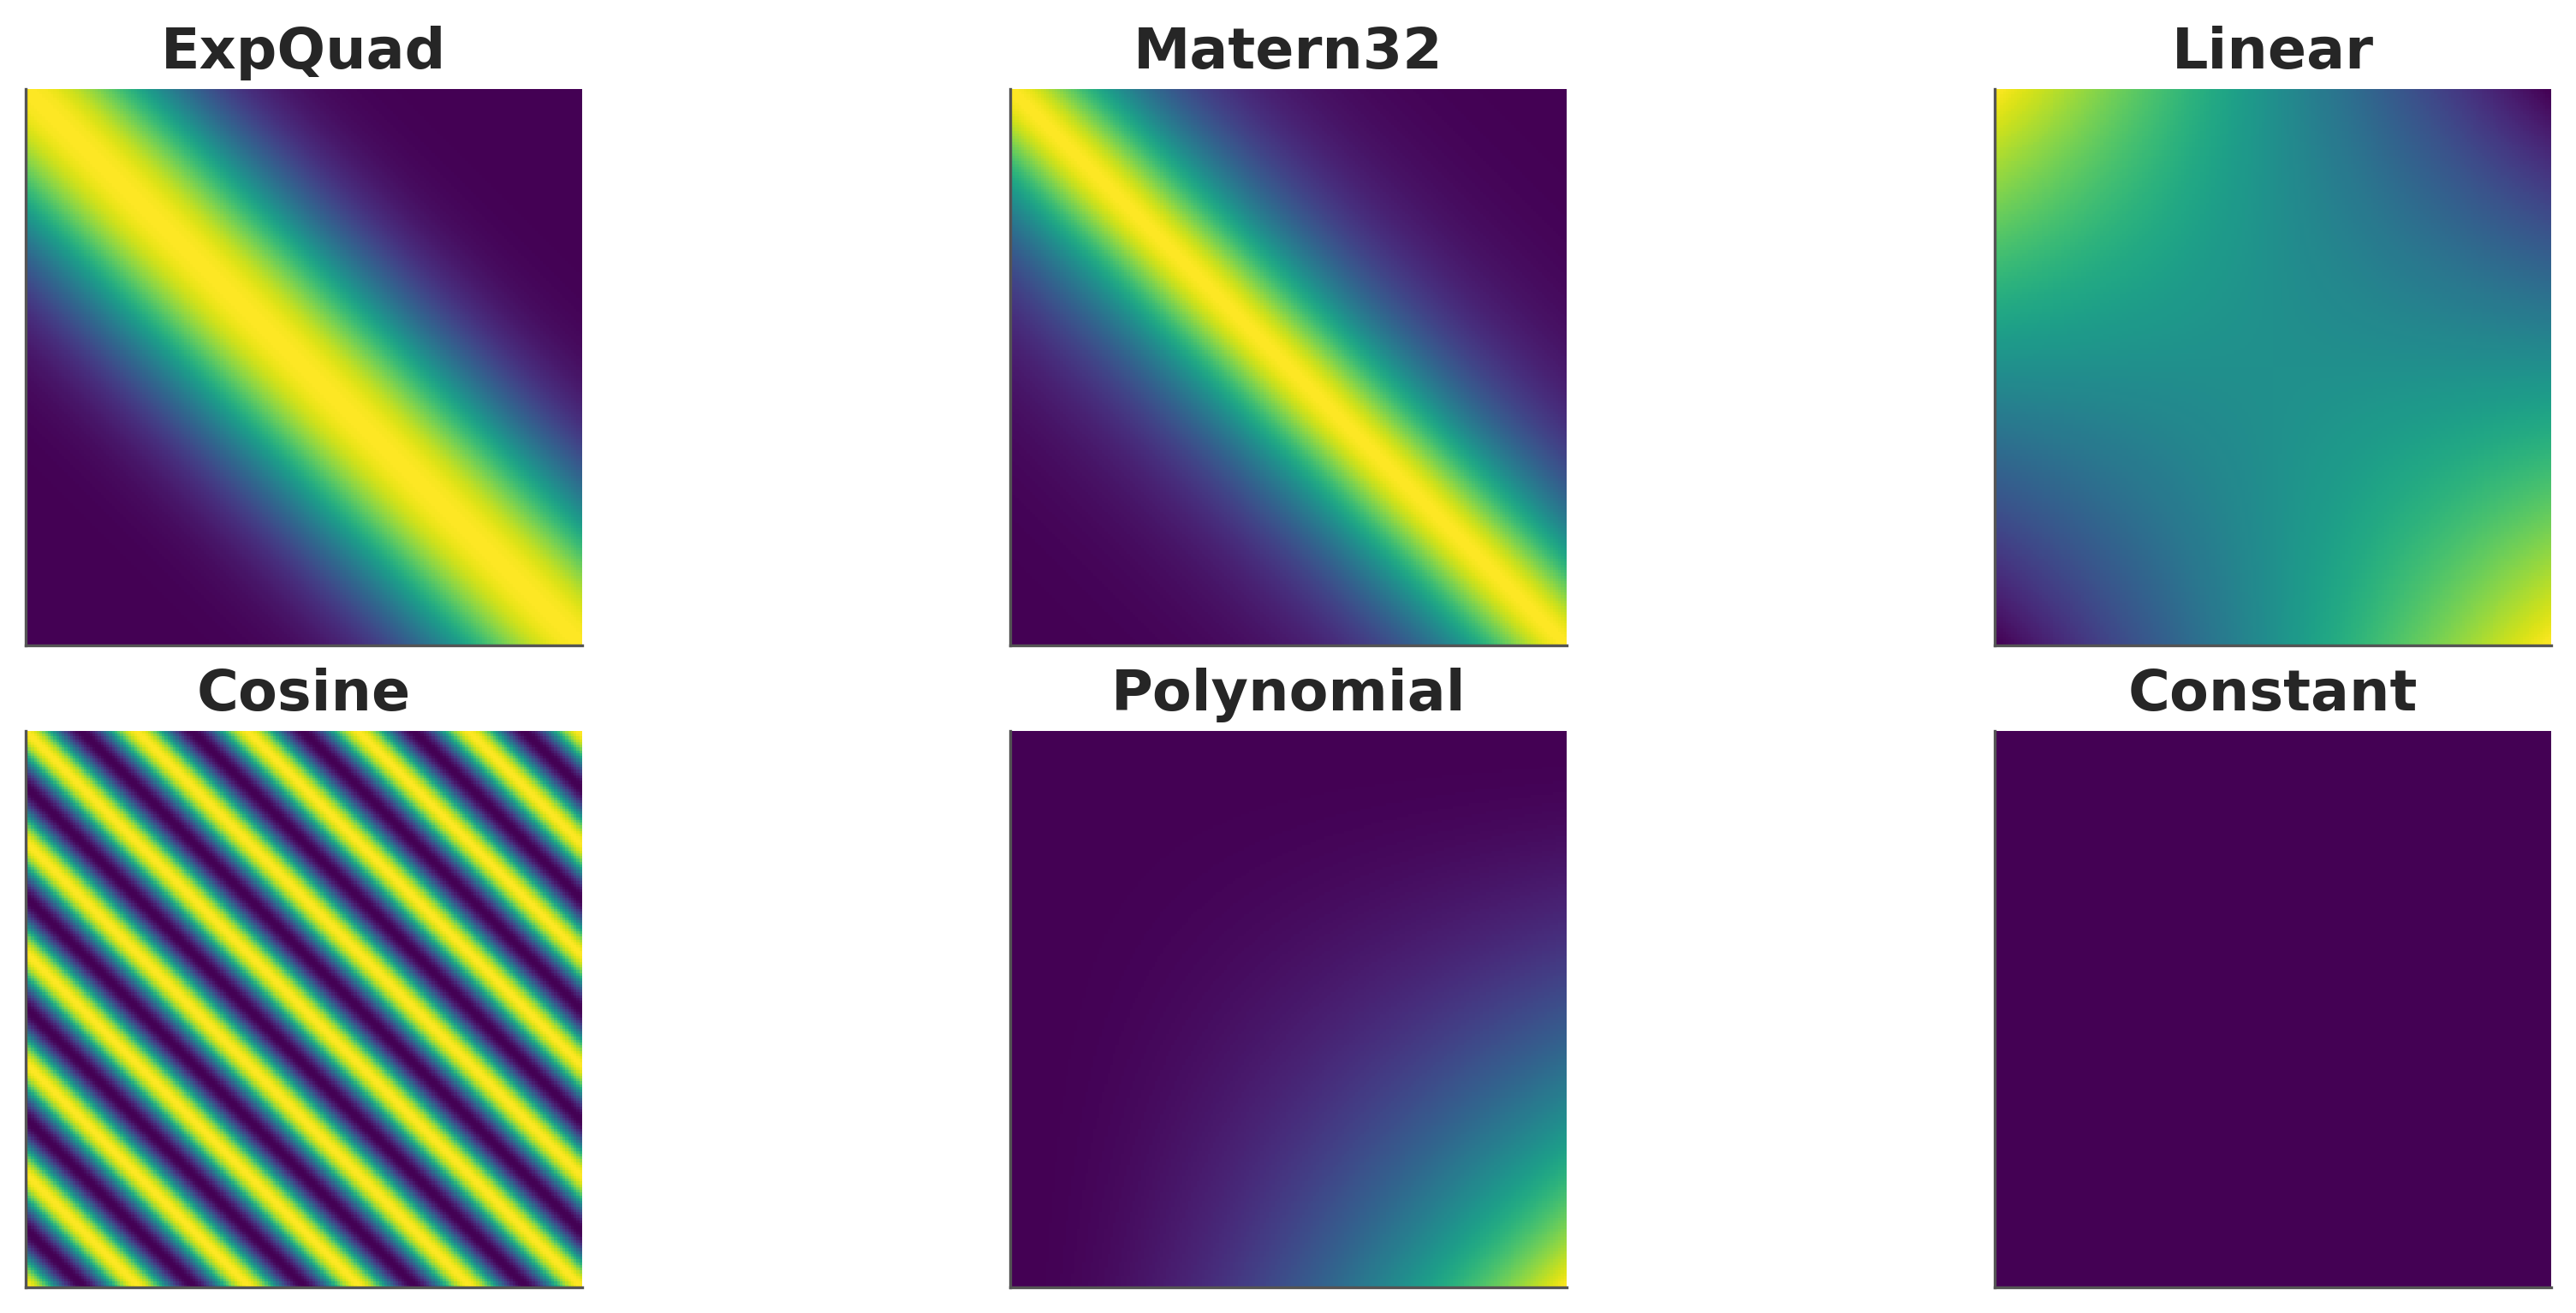

In [9]:
#| code-fold: true
X = np.linspace(0, 5, 200)[:,None]

fig, ax = plt.subplots(2, 3, sharex=True, sharey=True)
covs = [pm.gp.cov.ExpQuad(input_dim=1, ls=1), 
        pm.gp.cov.Matern32(input_dim=1, ls=1),
        pm.gp.cov.Linear(input_dim=1, c=2.5),
        pm.gp.cov.Cosine(input_dim=1, ls=1),
        pm.gp.cov.Polynomial(input_dim=1, c=0, d=2, offset=0),
        pm.gp.cov.Constant(c=1),
       ]
        
for cov, ax in zip(covs, ax.ravel()):
    m = ax.imshow(cov(X).eval())
    ax.set_title(cov.__class__.__name__)
ax.set_xticks([])
ax.set_yticks([]);

A continuación vamos a usar algo que quizá es más intuitivo que analizar matrices de covarianzas. Vamos a muestrar GPs, para distinos kernels con distintos parámetros.

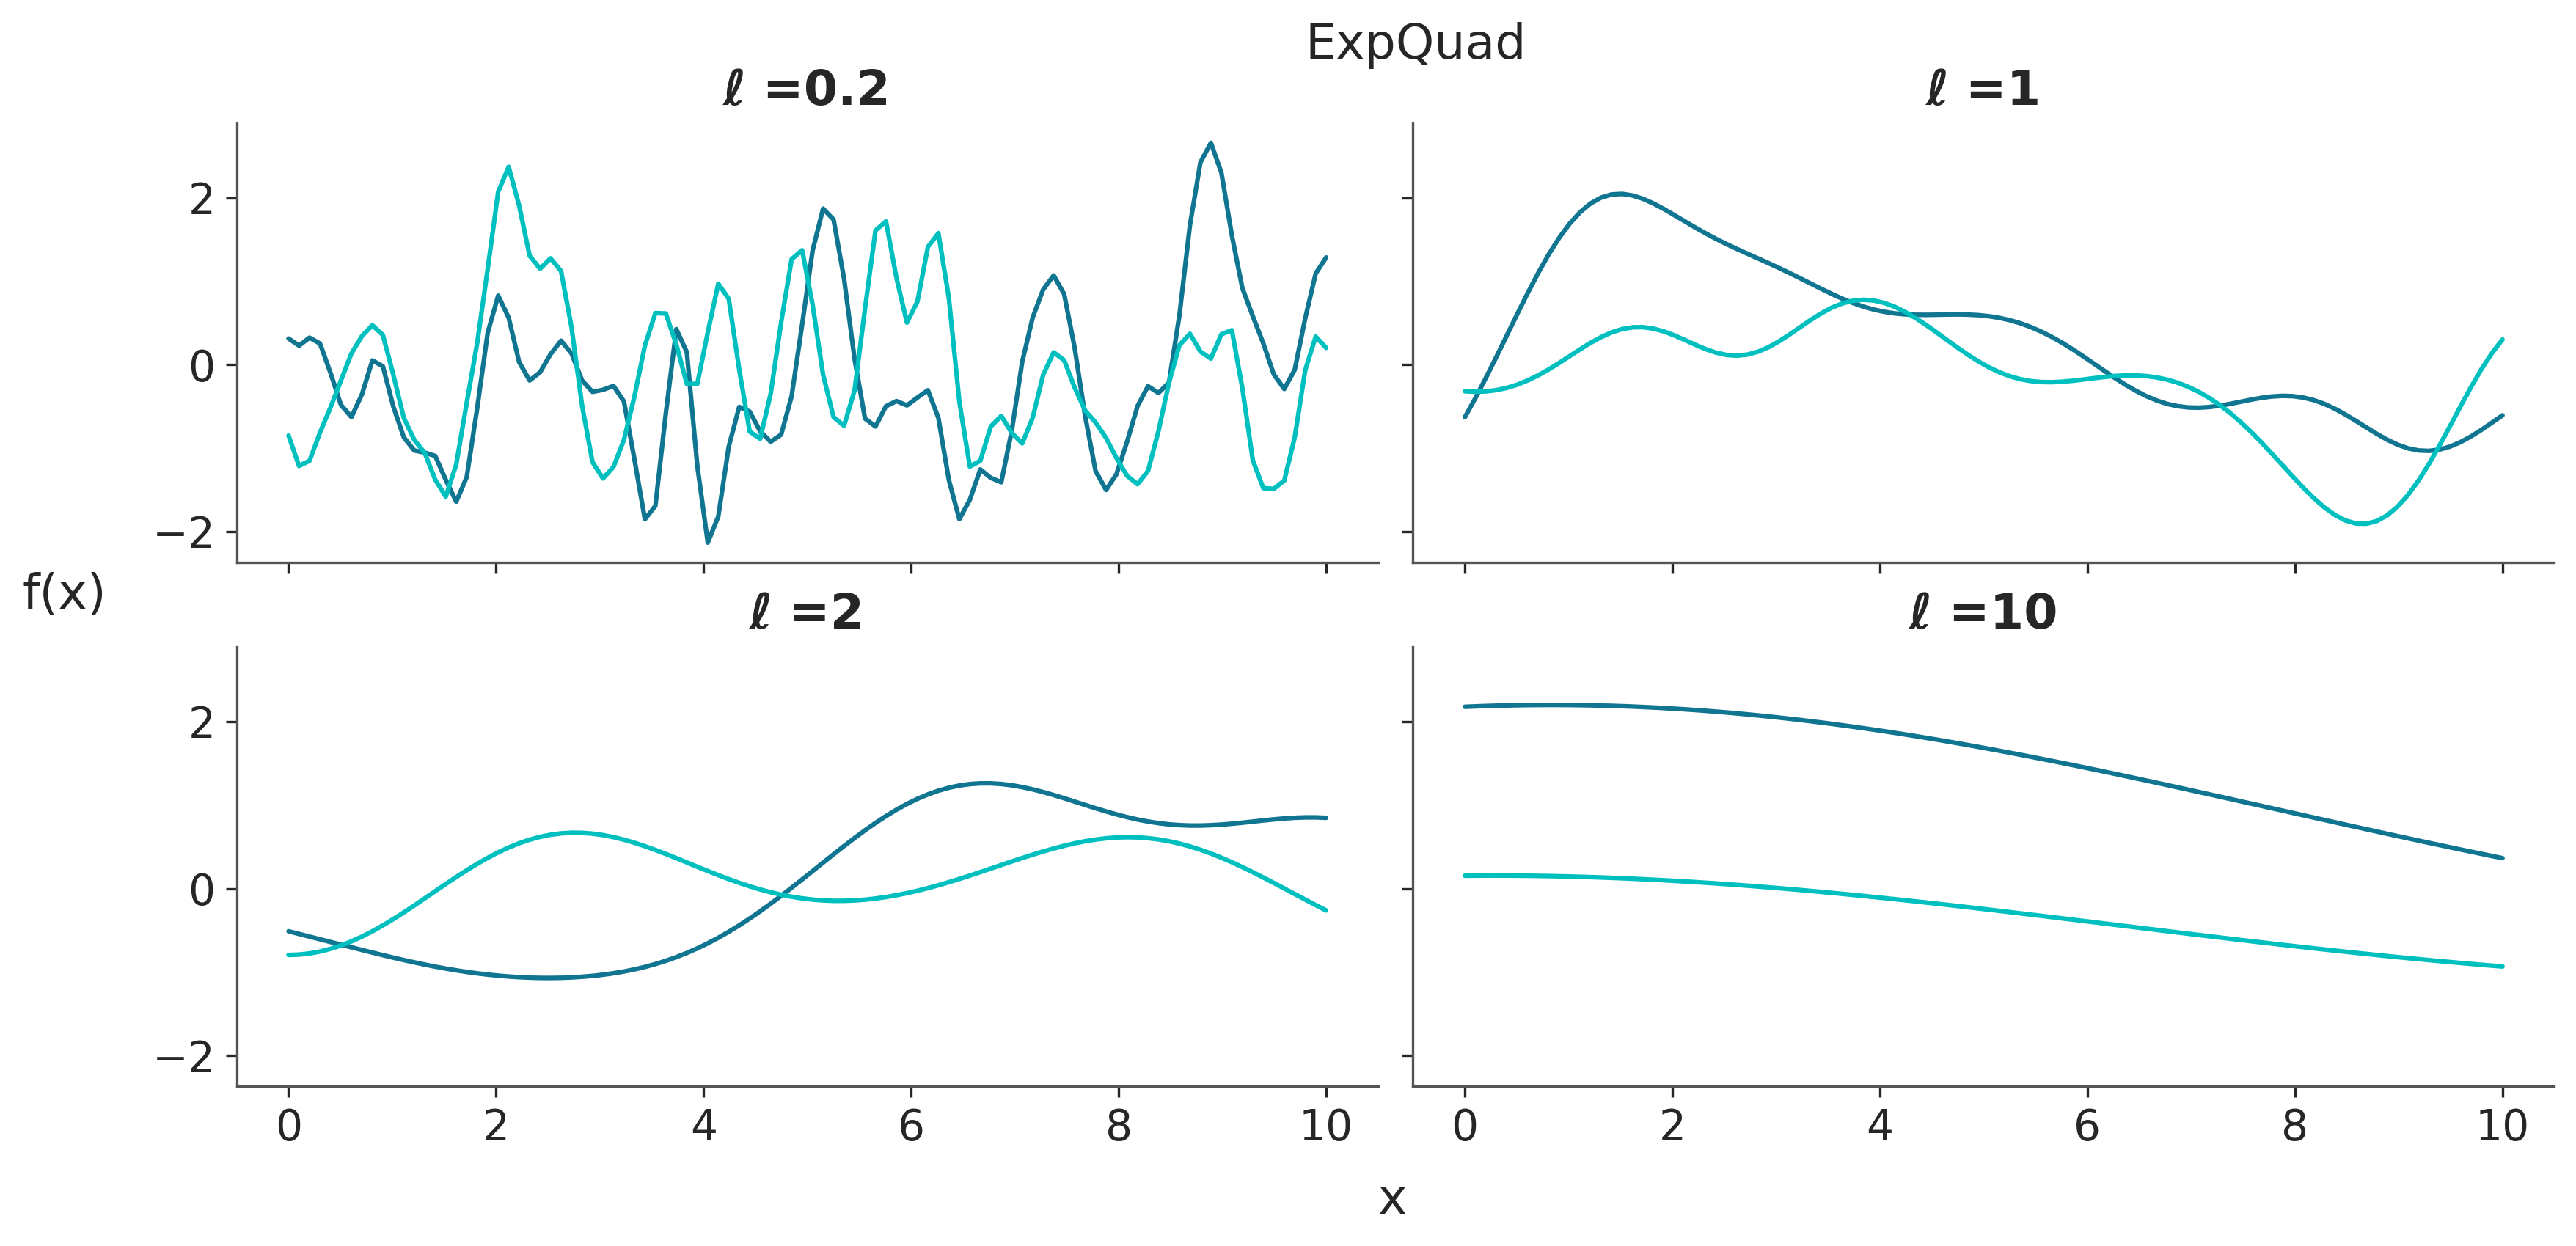

In [10]:
#| code-fold: true
np.random.seed(24)
test_points = np.linspace(0, 10, 100)[:,None]
fig, ax = plt.subplots(2, 2, figsize=(11, 5), sharex=True, sharey=True)
ax = np.ravel(ax)

for idx, ℓ in enumerate((0.2, 1, 2, 10)):
    cov = pm.gp.cov.ExpQuad(input_dim=1, ls=ℓ)
    ax[idx].plot(test_points, pz.MvNormal(mu=np.zeros_like(test_points)[:,0],
                                          cov=cov(test_points).eval()).rvs(2).T)
    ax[idx].set_title(f'ℓ ={ℓ}')
fig.text(0.48, 1, 'ExpQuad', fontsize=16)
fig.text(0.51, -0.05, 'x', fontsize=16)
fig.text(-0.05, 0.5, 'f(x)', fontsize=16);

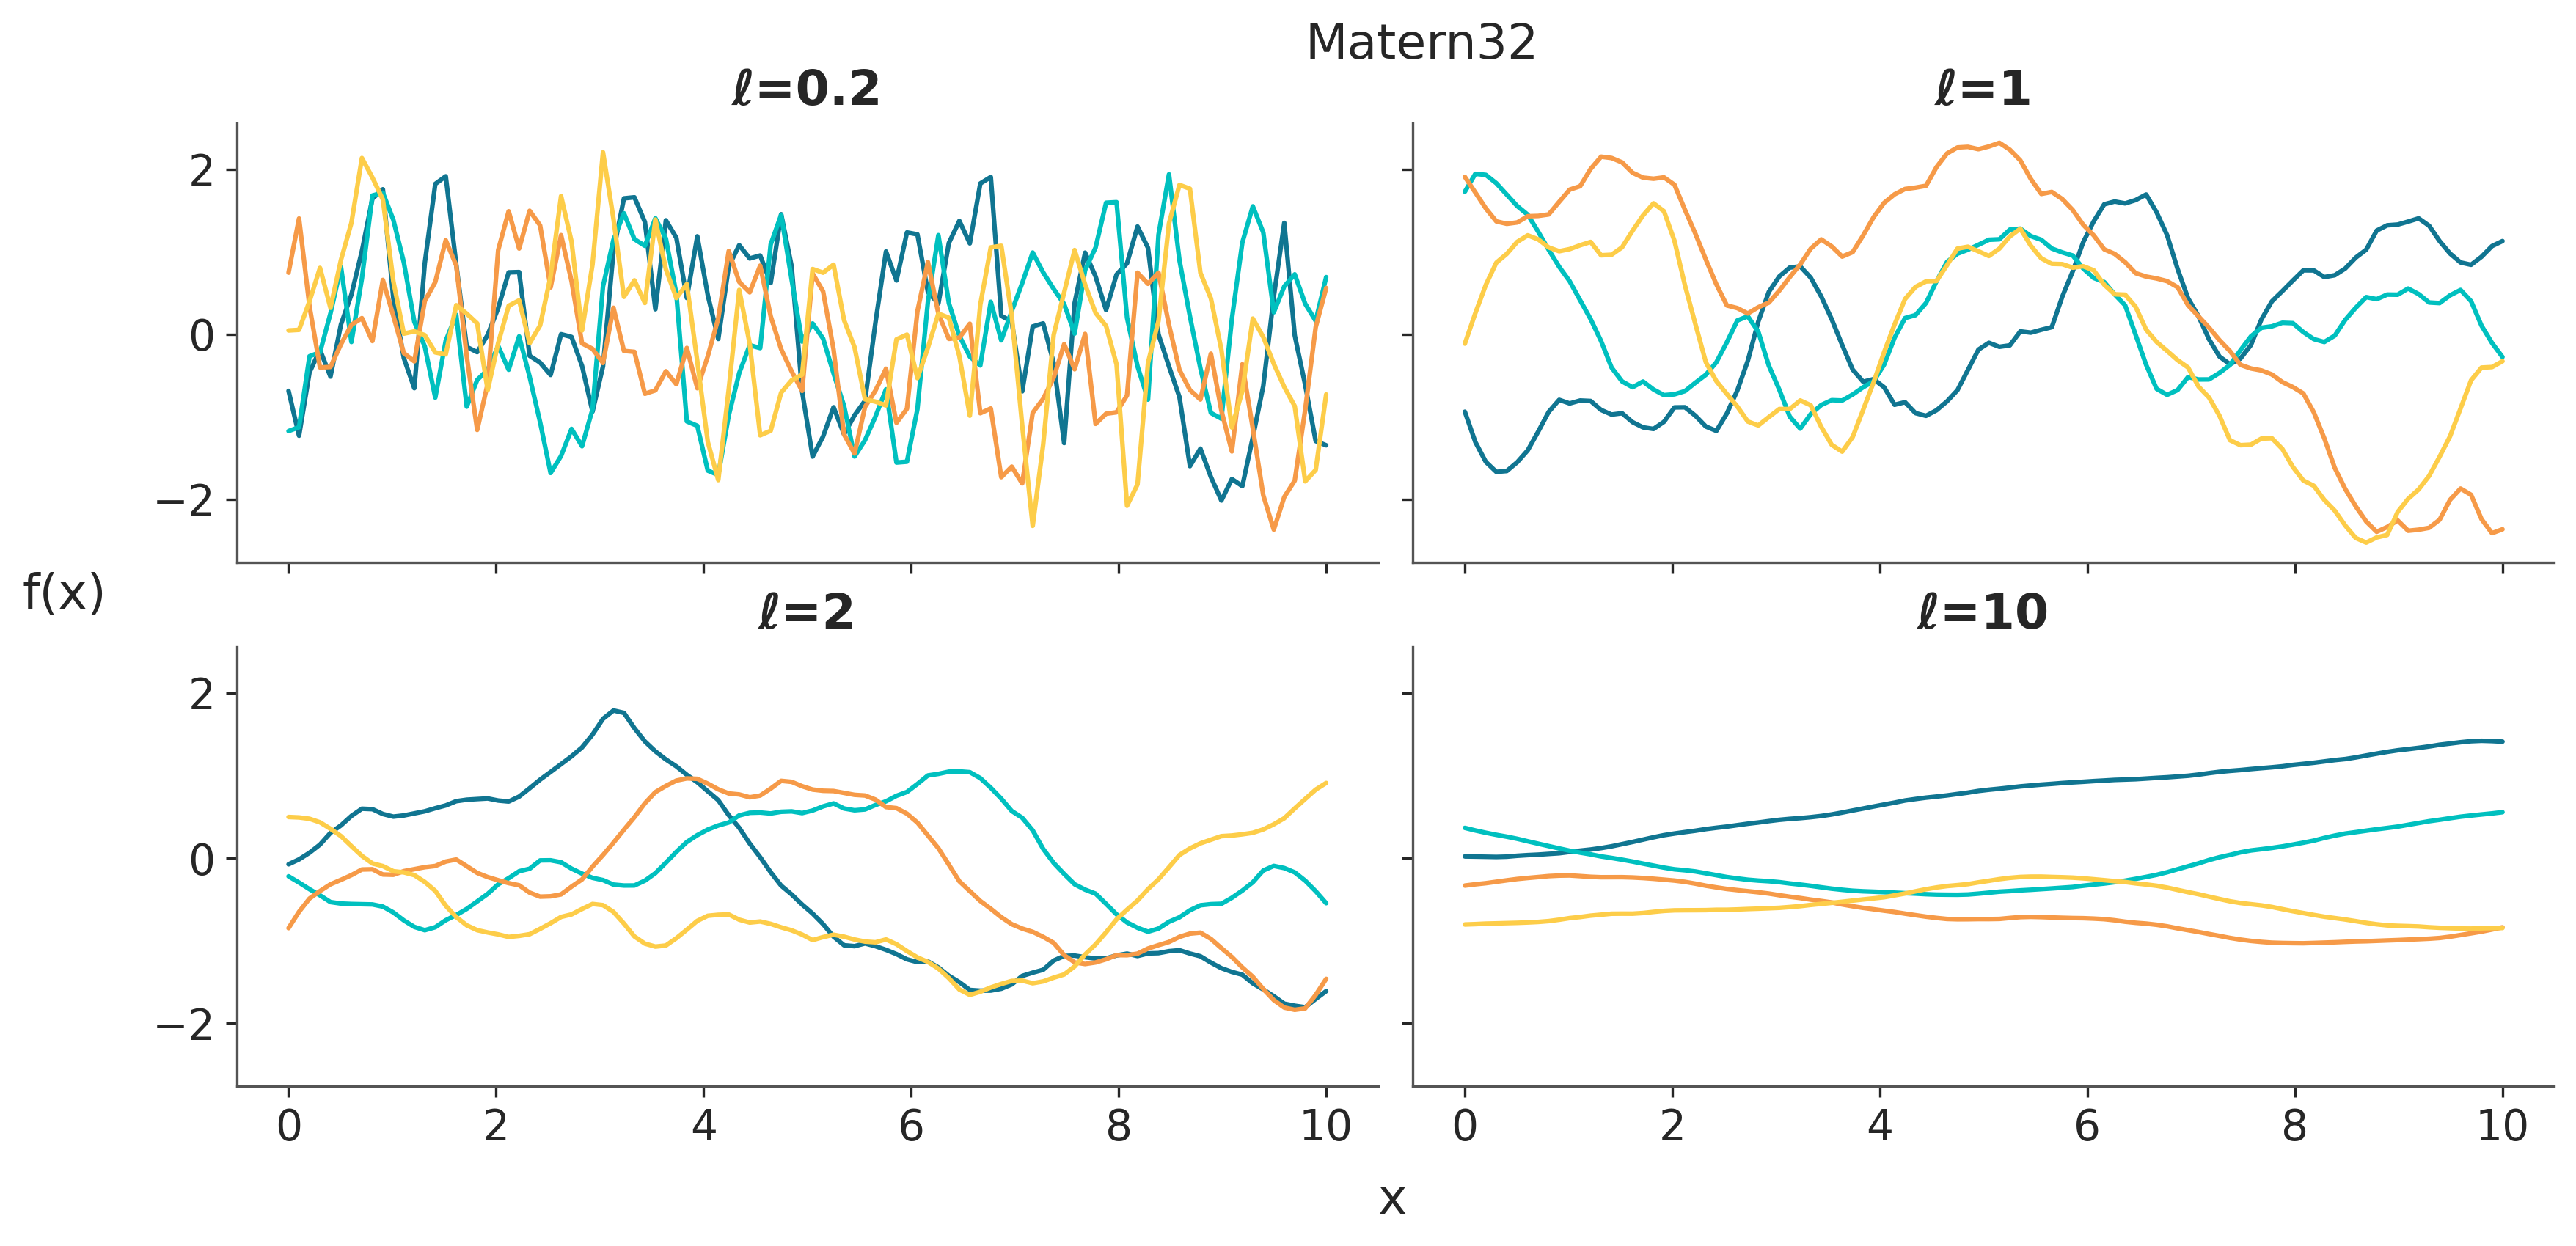

In [11]:
#| code-fold: true
np.random.seed(24)
test_points = np.linspace(0, 10, 100)[:,None]
fig, ax = plt.subplots(2, 2, figsize=(11, 5), sharex=True, sharey=True)
ax = np.ravel(ax)

for idx, ℓ in enumerate((0.2, 1, 2, 10)):
    cov = pm.gp.cov.Matern32(input_dim=1, ls=ℓ)
    ax[idx].plot(test_points, pz.MvNormal(mu=np.zeros_like(test_points)[:,0],
                                          cov=cov(test_points).eval()).rvs(4).T)
    ax[idx].set_title(f'ℓ={ℓ}')
fig.text(0.48, 1, 'Matern32', fontsize=16)
fig.text(0.51, -0.05, 'x', fontsize=16)
fig.text(-0.05, 0.5, 'f(x)', fontsize=16);

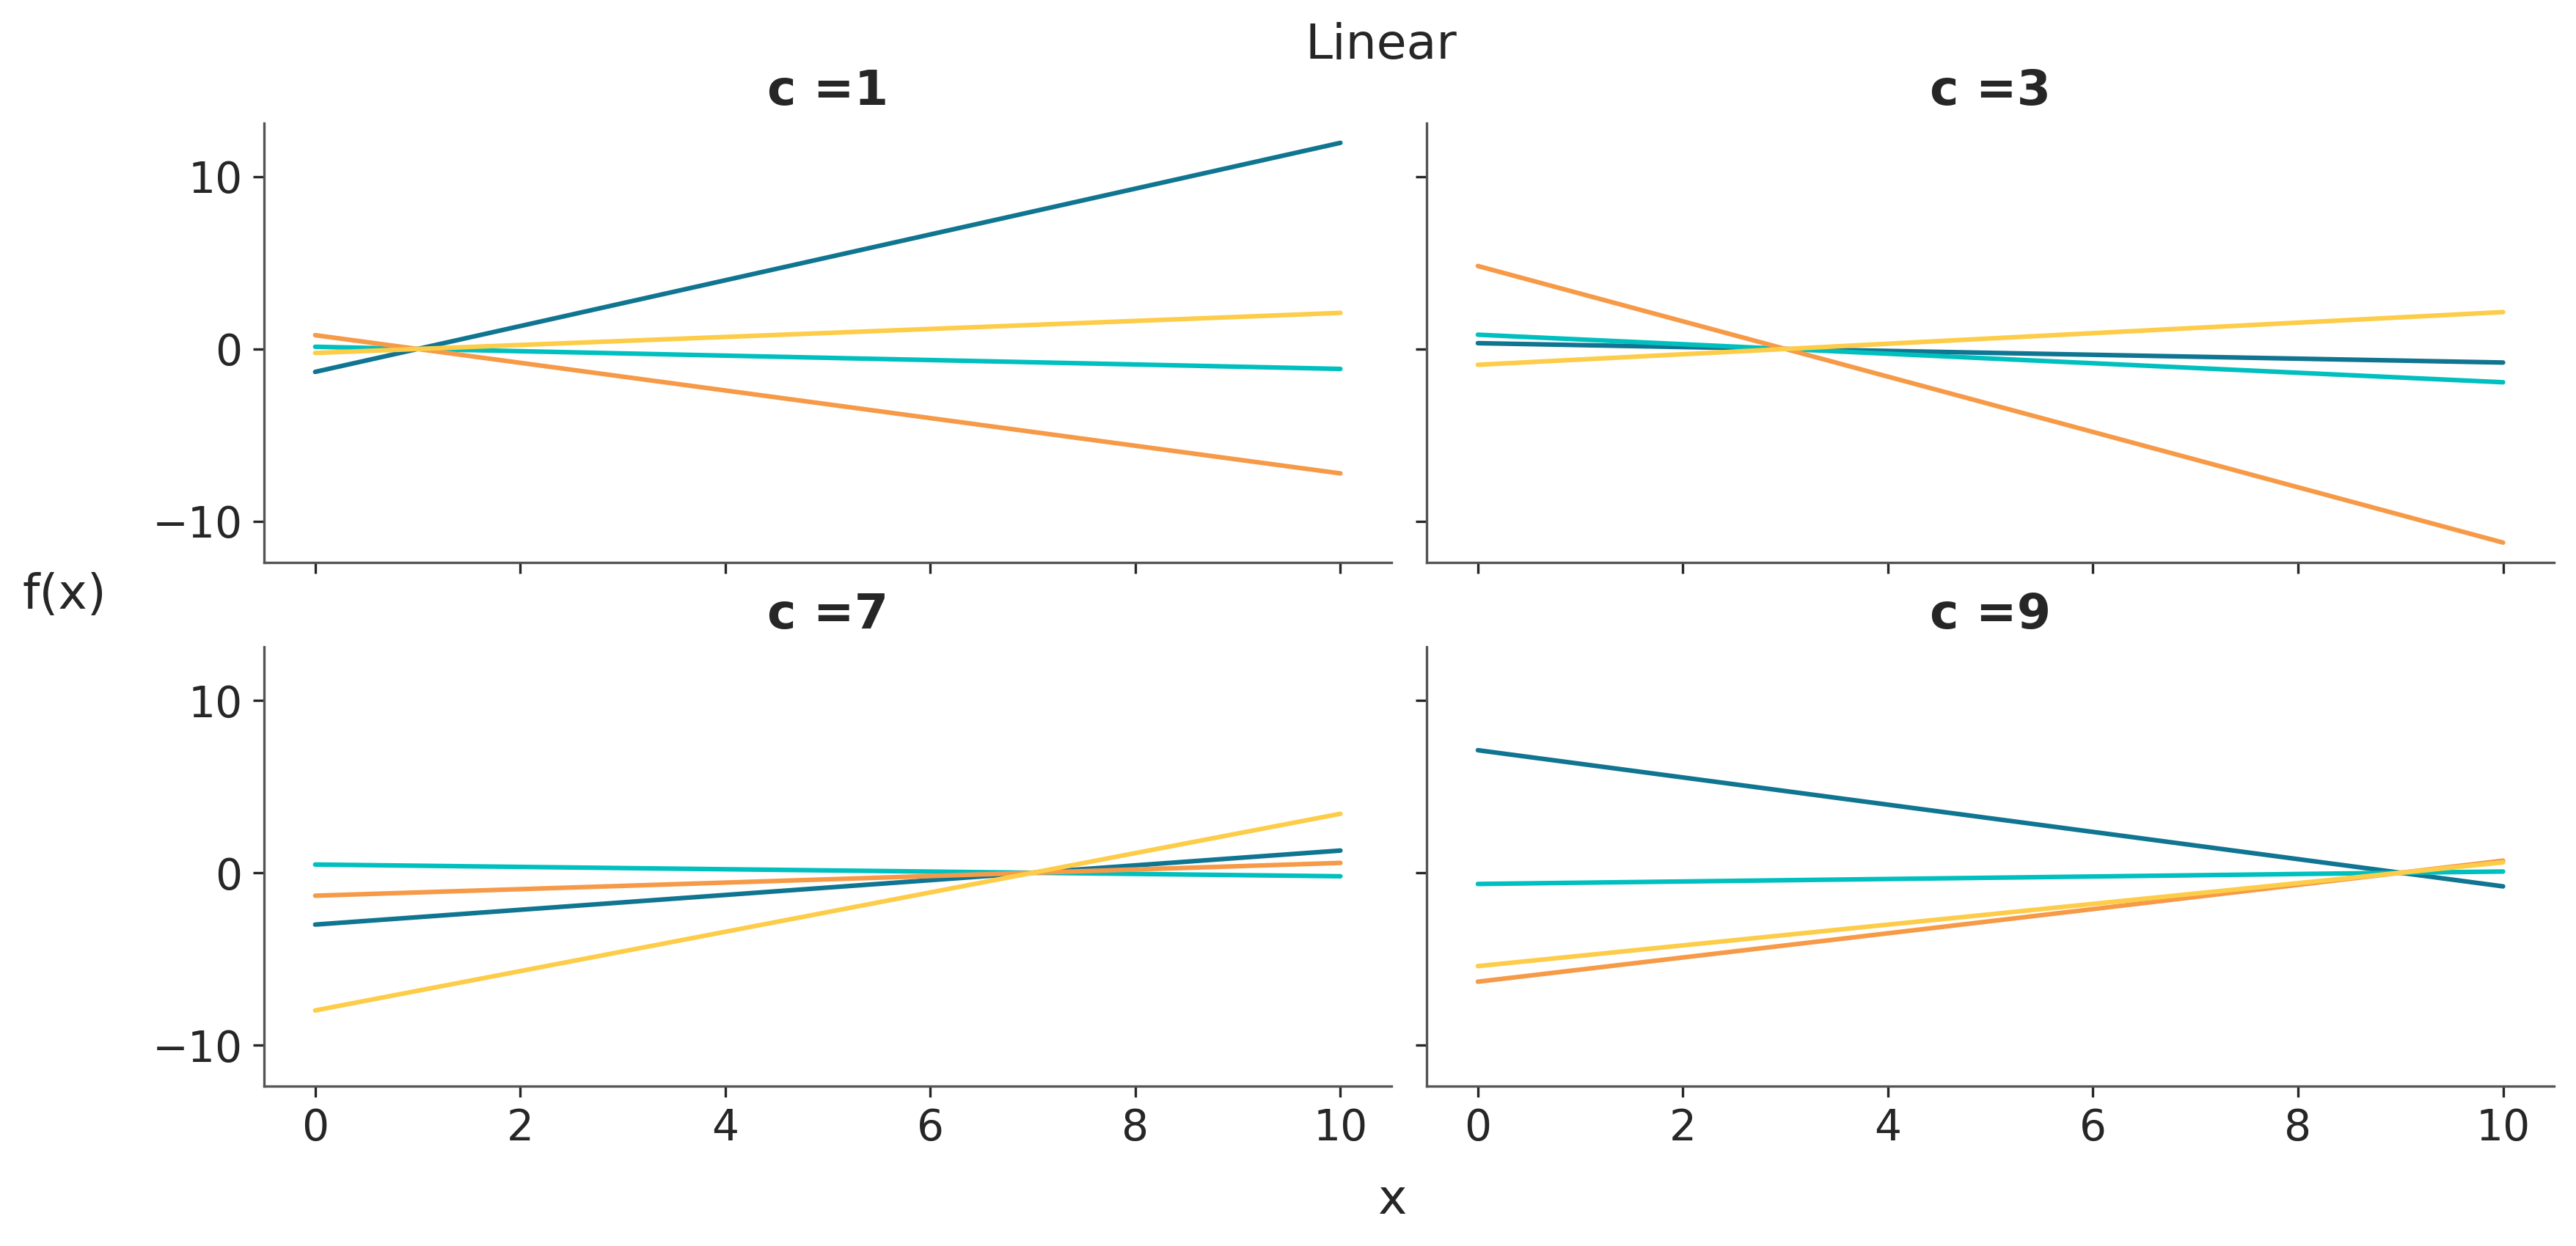

In [12]:
#| code-fold: true
np.random.seed(24)
test_points = np.linspace(0, 10, 100)[:,None]
fig, ax = plt.subplots(2, 2, figsize=(11, 5), sharex=True, sharey=True)
ax = np.ravel(ax)

for idx, c in enumerate((1, 3, 7, 9)):
    cov = pm.gp.cov.Linear(input_dim=1, c=c)
    ax[idx].plot(test_points, pz.MvNormal(mu=np.zeros_like(test_points)[:,0],
                                          cov=cov(test_points).eval()).rvs(4).T)
    ax[idx].set_title(f'c ={c}')
fig.text(0.48, 1, 'Linear', fontsize=16)
fig.text(0.51, -0.05, 'x', fontsize=16)
fig.text(-0.05, 0.5, 'f(x)', fontsize=16);

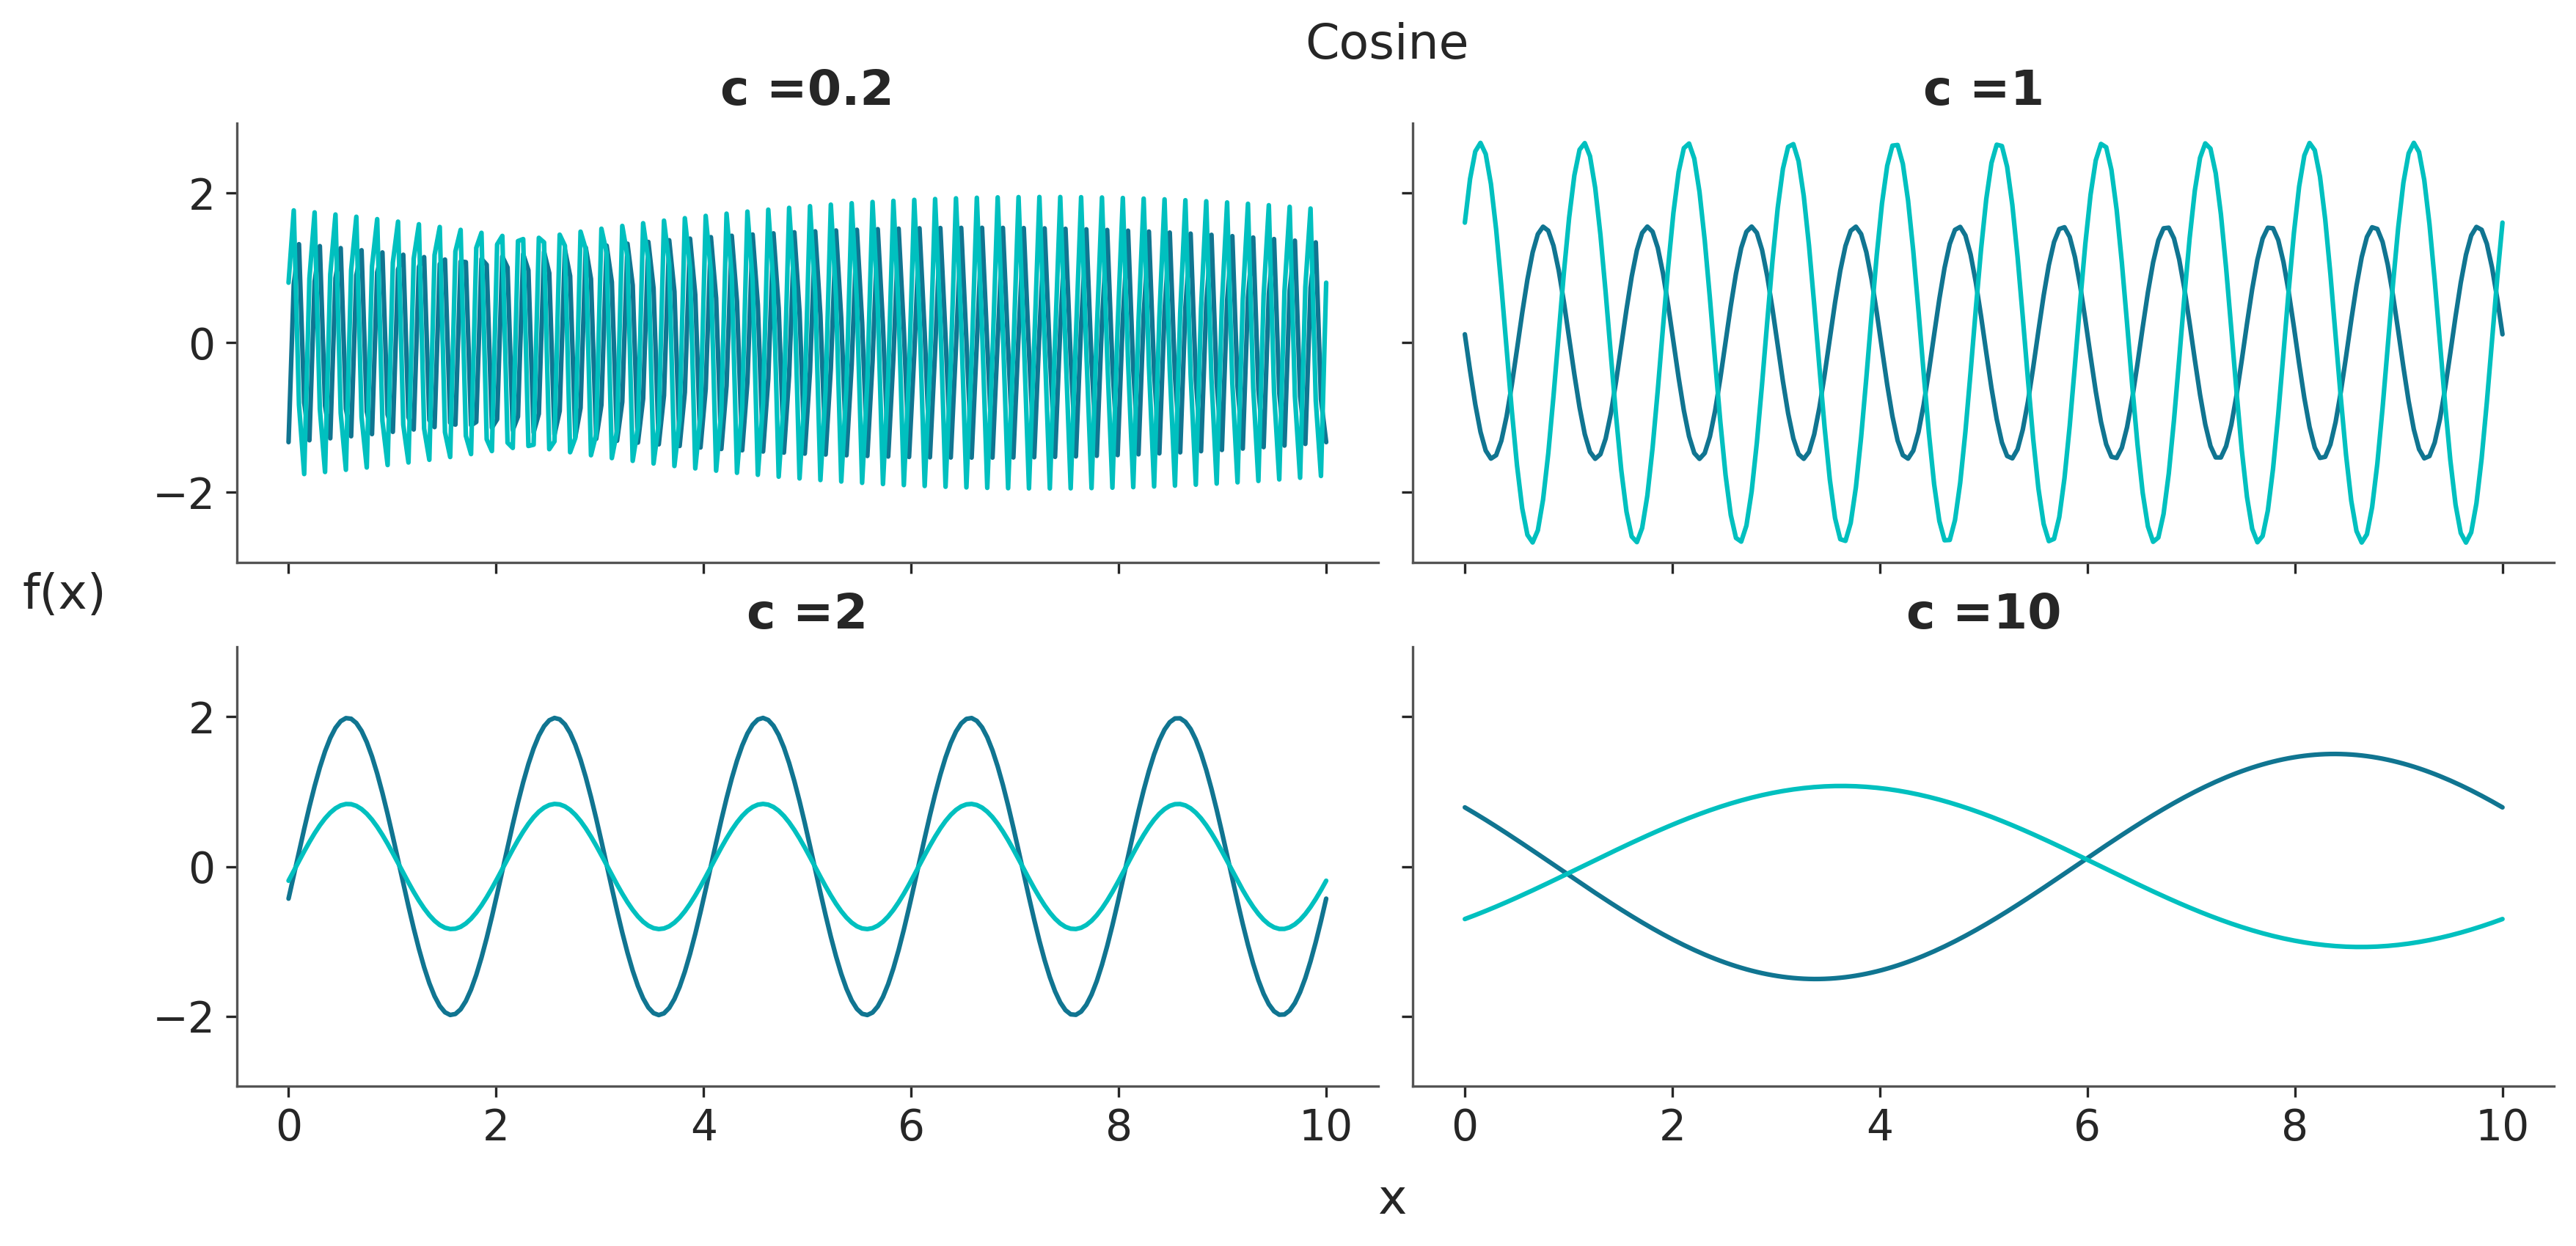

In [13]:
#| code-fold: true
np.random.seed(24)
test_points = np.linspace(0, 10, 200)[:,None]
fig, ax = plt.subplots(2, 2, figsize=(11, 5), sharex=True, sharey=True)
ax = np.ravel(ax)

for idx, ℓ in enumerate((0.2, 1, 2, 10)):
    cov = pm.gp.cov.Cosine(input_dim=1, ls=ℓ)
    ax[idx].plot(test_points, pz.MvNormal(mu=np.zeros_like(test_points)[:,0],
                                          cov=cov(test_points).eval()).rvs(2).T)
    ax[idx].set_title(f'c ={ℓ}')
fig.text(0.48, 1, 'Cosine', fontsize=16)
fig.text(0.51, -0.05, 'x', fontsize=16)
fig.text(-0.05, 0.5, 'f(x)', fontsize=16);

## GPs y regresión

Los procesos gaussianos son distribuciones a priori sobre funciones, es decir podemos escribir


$$
f(x) \sim \mathcal{GP}(\mathbf{\mu}, \mathbf{\Sigma})
$$

Donde $\mathcal{GP}$ representa un proceso Gaussiano con función media $\mathbf{\mu}$ y función de covarianza $\mathbf{\Sigma}$. 

Si la distribución a priori es un GP y el likelihood es una Gaussiana con varianza $\sigma^2$, entonces la distribución a posteriori es también un GP de la siguiente forma:

$$
p(Y \mid \psi, \sigma) \sim \mathcal{N}(\mathbf{\mu}_{\text{post}}, \mathbf{\Sigma}_{\text{post}})
$$

Donde $k$ es un kernel con (hiper)parámetros $\psi$ y

$$
\mathbf{\mu}_{\text{post}} =  k(\mathbf{X}, \mathbf{X'}) \left[k(\mathbf{X}, \mathbf{X}) + \sigma^2 I \right]^{-1} Y
$$

$$
\mathbf{\Sigma}_{\text{post}} = k(\mathbf{X'}, \mathbf{X'}) - k(\mathbf{X'}, \mathbf{X}) \left[ k(\mathbf{X}, \mathbf{X}) + \sigma^2 I \right]^{-1} k(\mathbf{X}, \mathbf{X'})
$$

Podemos ver que la función media es una función lineal de las observaciones $Y$. Podríamos pensar la media como $\sum_i^n w_i(x) yi$, donde los pesos $w$ provienen de la estructura del kernel/covarianza.

Respecto de la covarianza a posteriori cabe destacar que es menor que la covarianza marginal $k(\mathbf{X'}, \mathbf{X'})$. Esto es esperable ya que en general al observar datos esperamos "aprender" de ellos y por lo tanto reducir la incertidumbre a priori

## GPs y PyMC

PyMC tiene un módulo `gp`, el cual tiene distintas implementaciones de GPs, estas implementaciones varían, por ejemplo, si el likelihood es o no Gaussiano. A fin de ejemplificar su uso, generemos un dataset sintético.

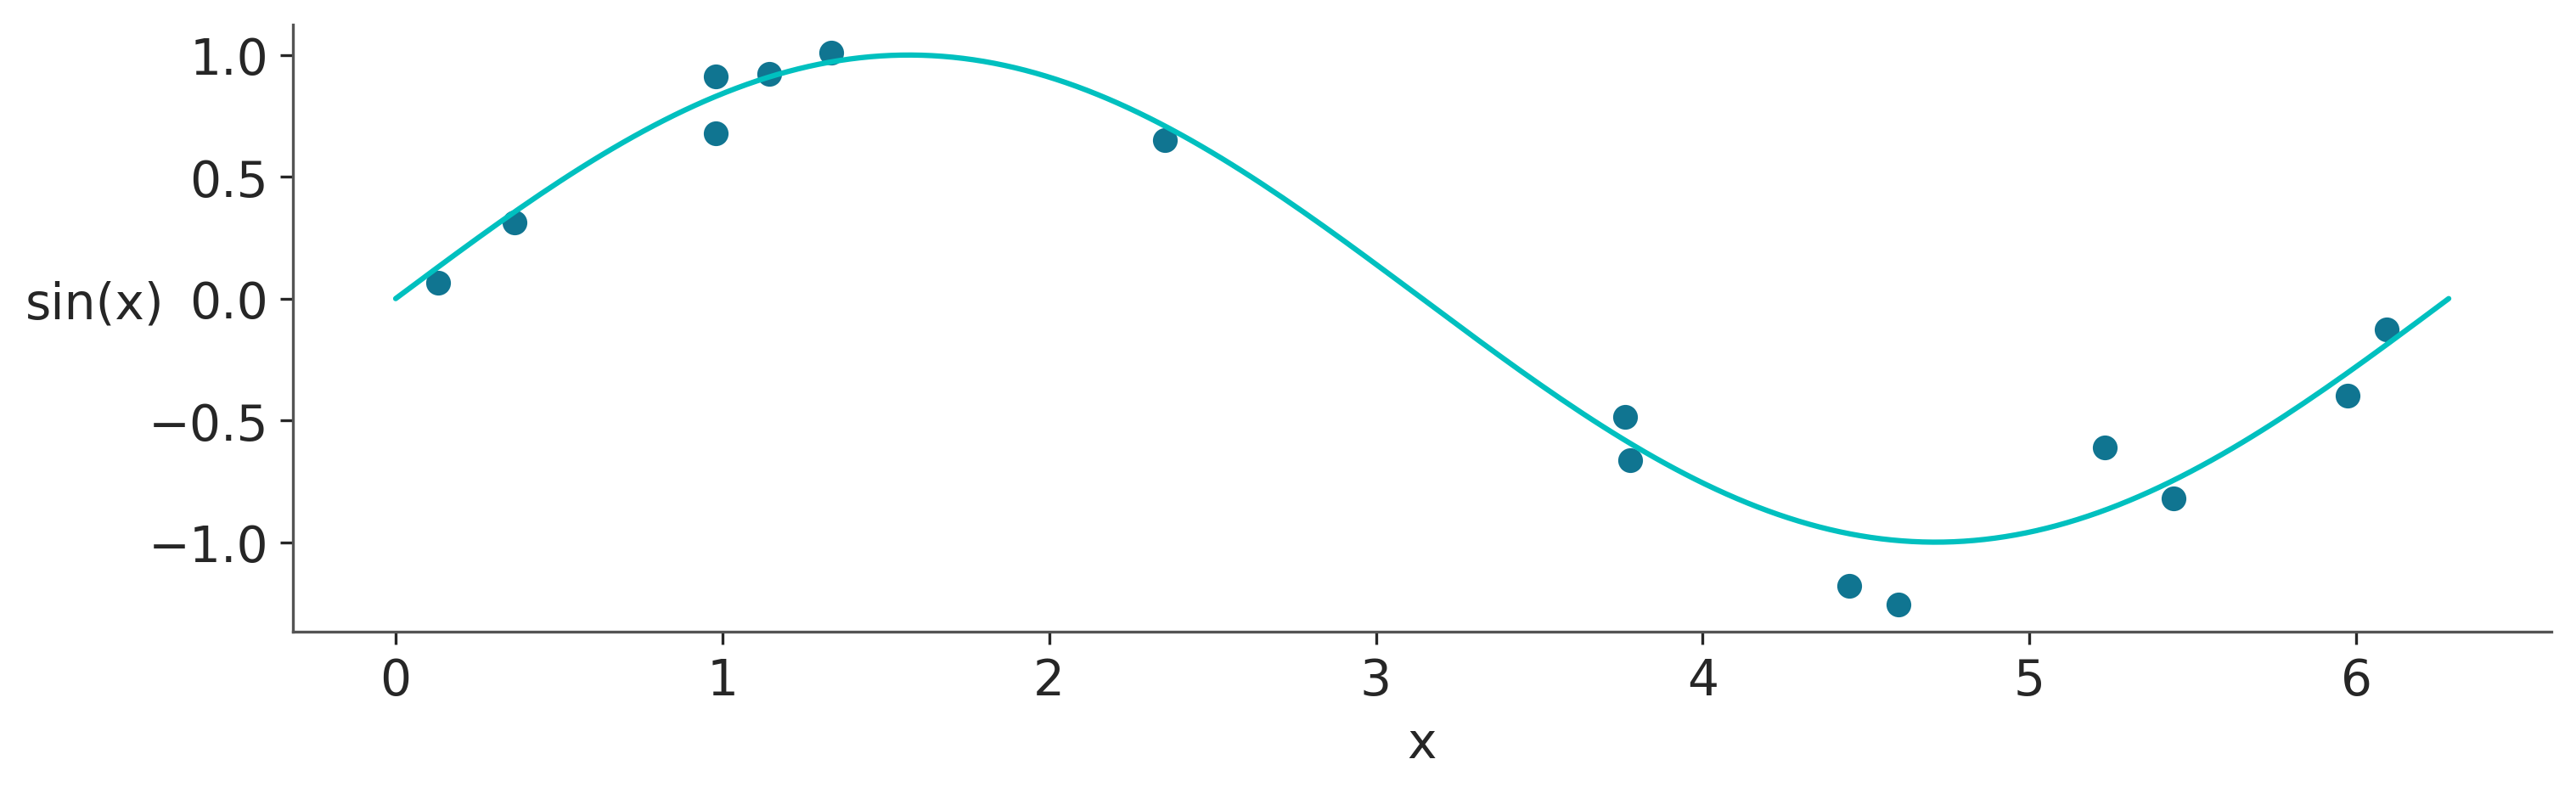

In [14]:
np.random.seed(42)
x = np.random.uniform(0, 2 * np.pi, size=15)
y = np.random.normal(np.sin(x), 0.1)


_, ax = plt.subplots(figsize=(10, 3))
ax.plot(x, y, 'o')
true_x = np.linspace(0, 2 * np.pi, 200)
ax.plot(true_x, np.sin(true_x), 'C1')
ax.set_xlabel('x')
ax.set_ylabel('sin(x)', rotation=0, labelpad=15);

In [15]:
# Se espera que X tenga dimensión 2, incluso si lo tenemos una variable/feature
X = x[:, None]

with pm.Model() as modelo_reg:
    # hyperprior para la longitud de escala
    ℓ = pm.Exponential("ℓ", 0.5)
    
    # instanciamos la función de covarianza
    cov = pm.gp.cov.ExpQuad(1, ls=ℓ)
    # instanciamos el GP (prior)
    gp = pm.gp.Marginal(cov_func=cov)

    σ = pm.HalfNormal('σ', 25)

    y_pred = gp.marginal_likelihood('y_pred', X=X, y=y, sigma=σ)
    idata_reg = pm.sample(random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ℓ, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


A fin de observar el ajuste vamos a evaluar el posterior GP en valores nuevos `X_new`. 

In [16]:
X_new = np.linspace(np.floor(x.min()), np.ceil(x.max()), 100)[:,None]

with modelo_reg:
    f_pred = gp.conditional('f_pred', X_new)

In [17]:
with modelo_reg:
    idata_reg_subset = idata_reg.sel(draw=slice(0, None, 100))
    pred_samples = pm.sample_posterior_predictive(idata_reg_subset,
                                                  var_names=["f_pred"],
                                                  random_seed=123)

f_pred = az.extract(pred_samples, group="posterior_predictive")['f_pred']

Sampling: [f_pred]


Output()

Como vimos con modelos lineales generalizados tenemos varias opciones para visualizar el ajuste. Una de ellas es graficar la funciones resultantes, en el caso de GLMs estas eran lineas en el caso de GPs, estas serán funciones más flexibles.

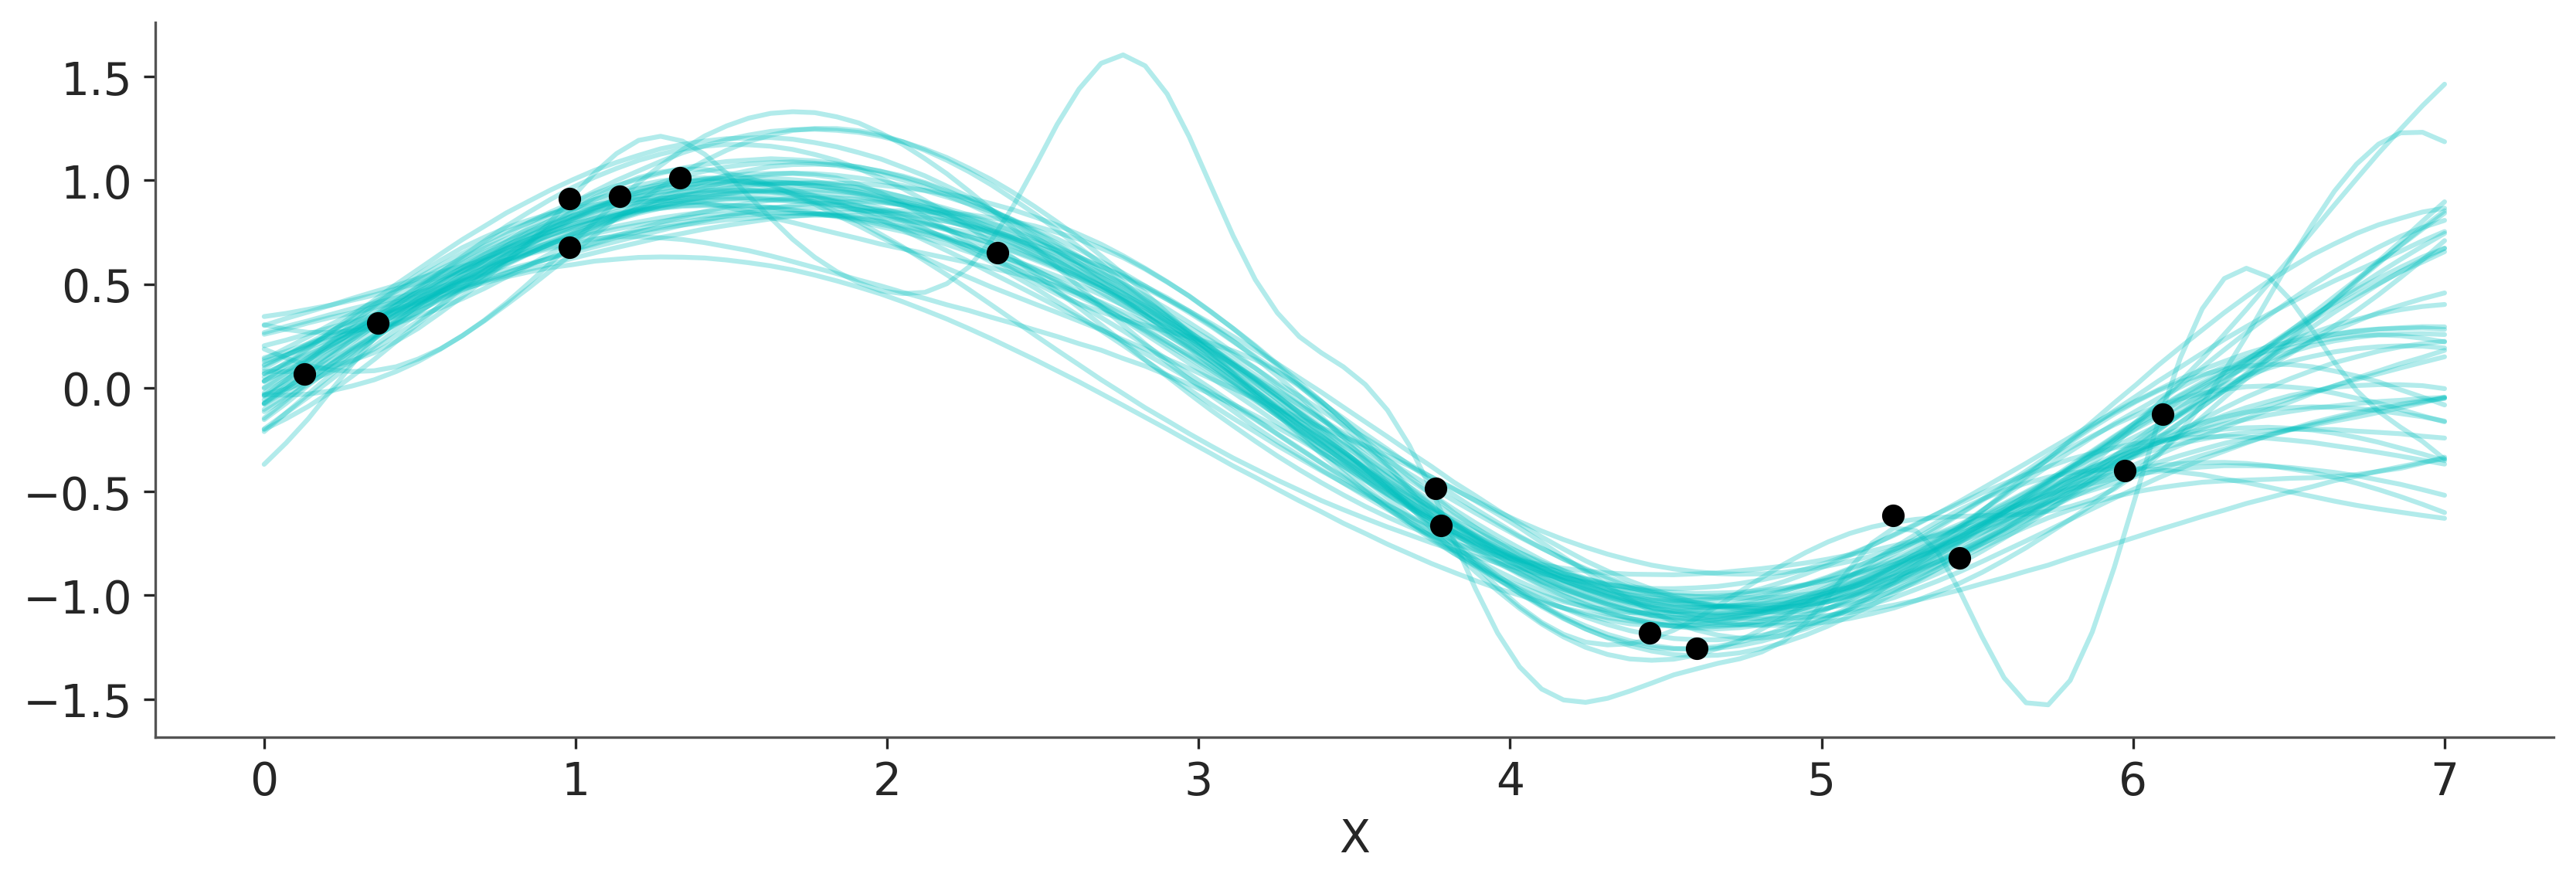

In [18]:
_, ax = plt.subplots(figsize=(11, 3.7))
ax.plot(X_new, f_pred, 'C1-', alpha=0.3)
ax.plot(X, y, 'ko')
ax.set_xlabel('X');

El módulo `gp` incluye algunas funciones para visualizar ajustes como `plot_gp_dist`. Esta función genera bandas para distinto percentiles desde 99 (azul claro) al 51 (azul oscuro).

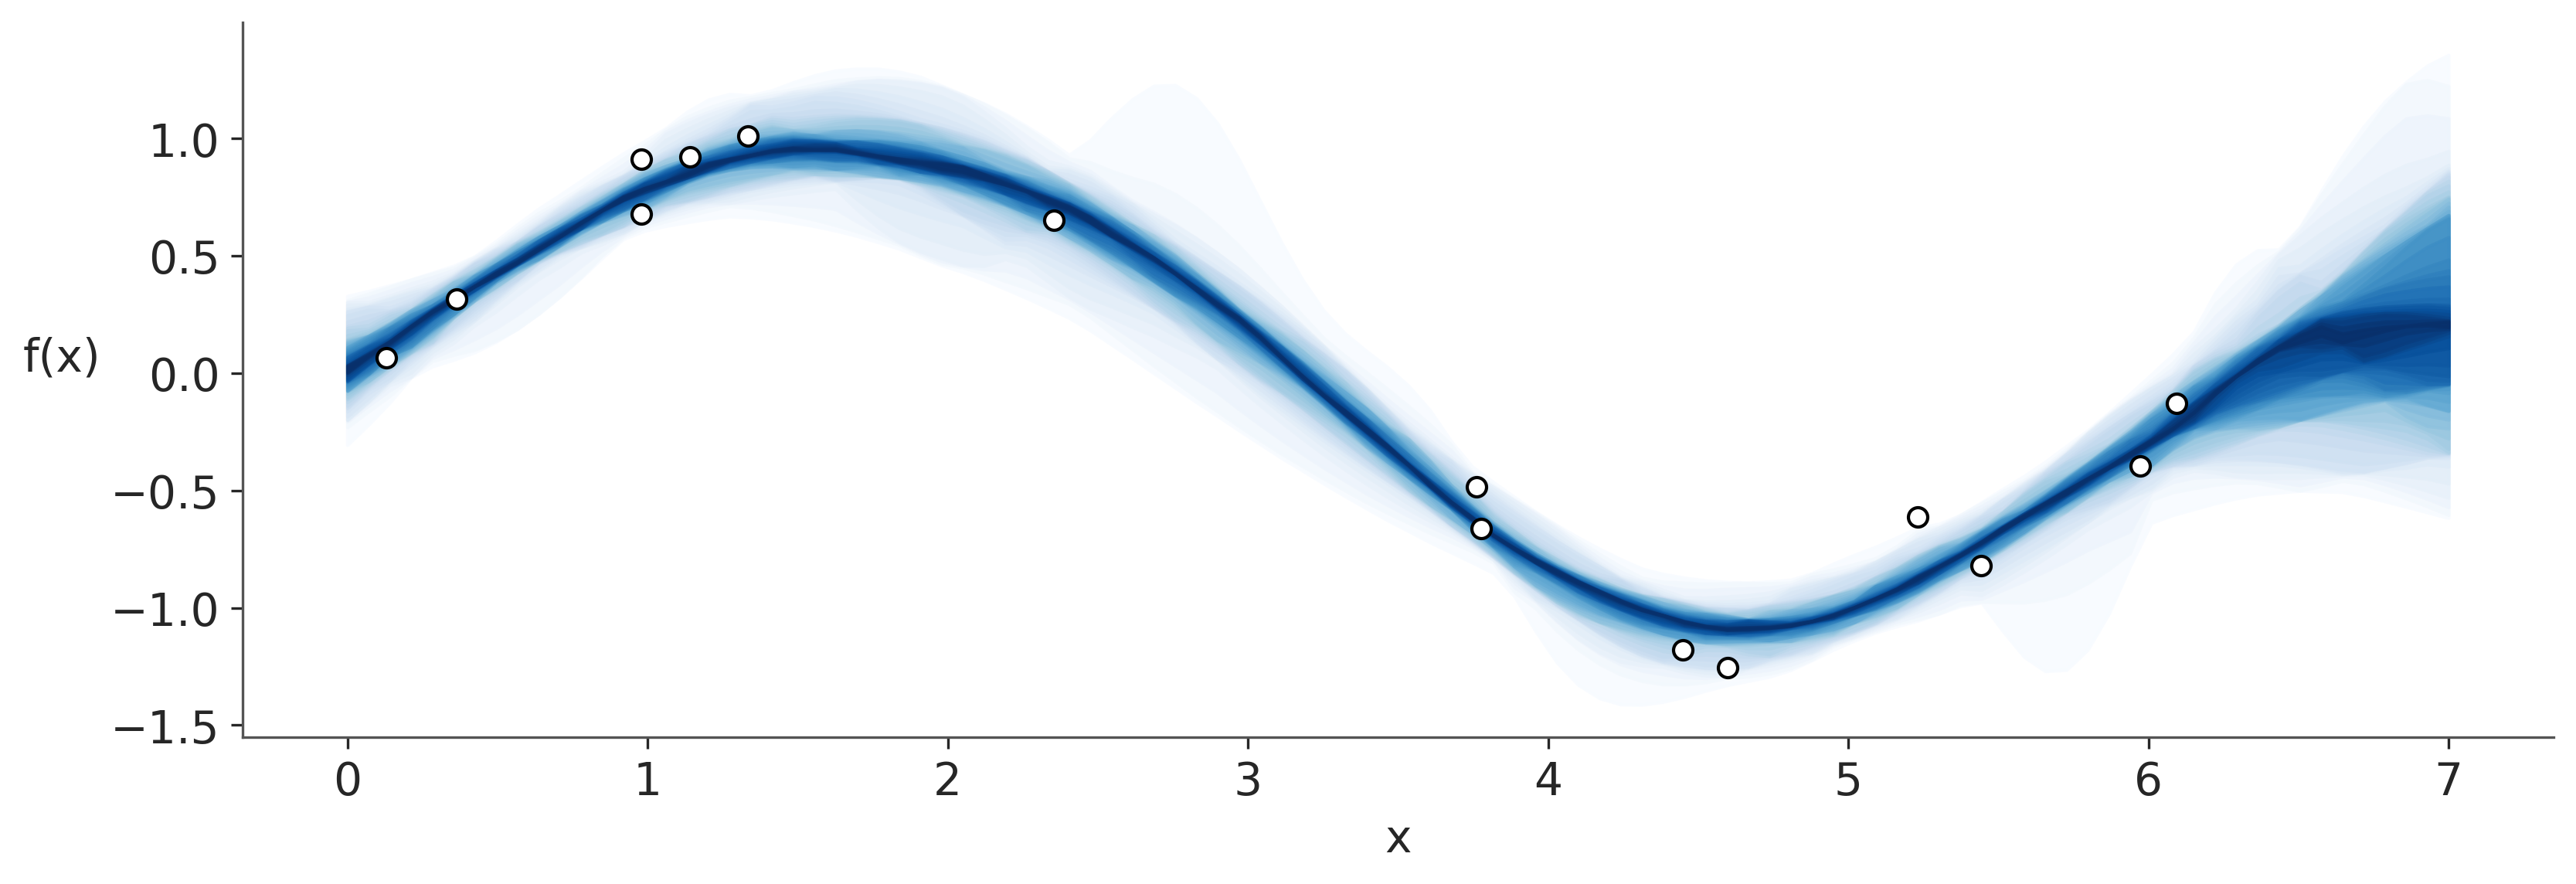

In [19]:
_, ax = plt.subplots(figsize=(11, 3.7))

pm.gp.util.plot_gp_dist(ax, f_pred.T, X_new, palette='Blues', plot_samples=False);

ax.plot(X, y, 'wo', mec='k')
ax.set_xlabel('x')
ax.set_ylabel('f(x)', rotation=0, labelpad=15);

Otra alternativa es computar el vector media y la desviación estándar como en la siguiente figura.

Text(0.5, 0, 'X')

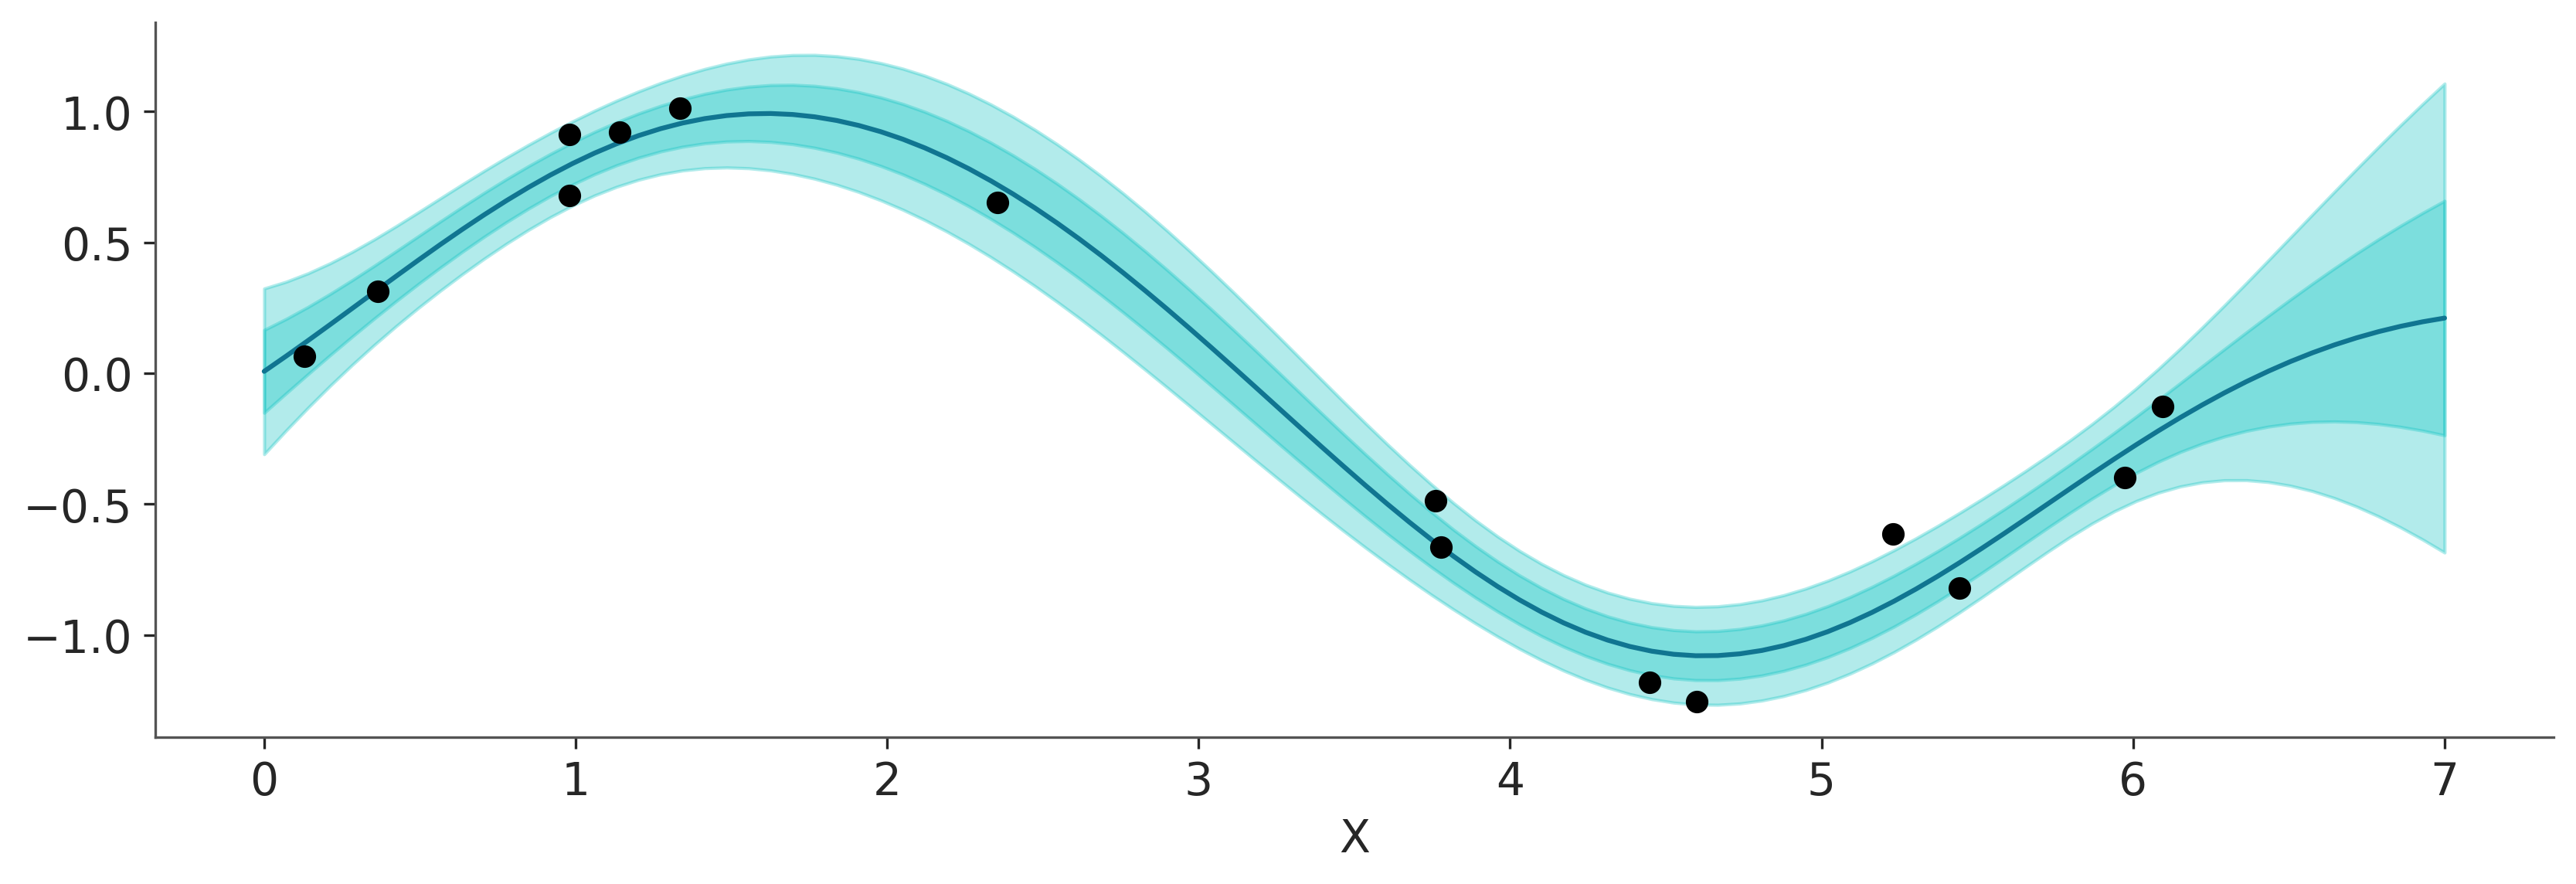

In [20]:
# plot the results
_, ax = plt.subplots(figsize=(11, 3.7))

# predict
point = {'ℓ': idata_reg.posterior['ℓ'].mean(), 'σ': idata_reg.posterior['σ'].mean()}
mu, var = gp.predict(X_new, point=point, diag=True,  model=modelo_reg)
sd = var**0.5

# plot mean and 1σ and 2σ intervals
ax.plot(X_new, mu, 'C0')
ax.fill_between(X_new.flatten(),
                 mu - sd, mu + sd,
                 color="C1",
                 alpha=0.3)

ax.fill_between(X_new.flatten(),
                 mu - 2*sd, mu + 2*sd,
                 color="C1",
                 alpha=0.3)

ax.plot(X, y, 'ko')
ax.set_xlabel('X')

## Prior para la longitud de escala

Al establecer una distribución a priori para la longitud de escala, las distribuciones que evitan el cero y/o asignan poca masa a valores _muy pequeños_ suelen funcionar mejor. Como ya vimos, $\ell$ controla cuan distintos son dos valores, un valor de 0 para $\ell$ implica que todo es distinto a todo. En un kernel como el cuadrático exponencial o Matern, esto implica funciones menos suaves, o que varían más rápido. 

Además, es deseables que los valores de $\ell$ se encuentren en el rango de los datos. Para valores por debajo del espaciado mínimo de las covariables o por encima del rango de los datos el likelihood no tiene forma de distinguir entre diferentes longitud de escala. Es decir todos los valores son equivalentes y tenemos un problema de no-identificabilidad. Esto se traducirá en un GP que tenderá a sobreajustar e interpolar exactamente entre los datos de entrada y en problemas de muestreo. 


Es por ello que es común usar distribuciones Gama o Gama Inversa ajustada _debilmente_ según los datos. Para el resto del capítulo usaremos la siguiente función para estimar de forma automática la distribución a priori para $\ell$.

In [21]:
def get_ig_params(x_vals, l_b=None, u_b=None, mass=0.95, plot=False):
    """
    Returns a weakly informative prior for the length-scale parameter of the GP kernel.
    """

    differences = np.abs(np.subtract.outer(x_vals, x_vals))
    if l_b is None:
        l_b = np.min(differences[differences != 0]) * 2
    if u_b is None:
        u_b = np.max(differences) / 1.5

    dist = pz.InverseGamma()
    pz.maxent(dist, l_b, u_b, mass, plot=plot)

    return dict(zip(dist.param_names, dist.params))

## GPs generalizados

Como vimos con los GLMs, podemos utilizar un modelo lineal con una verosimilitud no gaussiana y una función de enlace inversa adecuada para ampliar el rango de modelos lineales útiles. La misma idea aplica a los GPs. Podemos, por ejemplo, utilizar una verosimilitud de Poisson con una función inversa de enlace exponencial. Para un modelo como este, la distribución _a posteriori_ ya no es analíticamente tratable, pero, no obstante, podemos utilizar métodos numéricos para aproximarla. En las siguientes secciones, analizaremos este tipo de modelos.

## GPs para clasificación

Anteriormente vimos que una forma de crear un modelo de clasificación es usar un modelo lineal con un likelihood Bernoulli y la función logística como función inversa de enlace. Este modelo nos permite calcular la probabilidad que una observación pertenezca a la clase 1 ($P(Y=1)$), el resultado es por lo tanto continuo (entre 0 y 1), si deseamos dicotomizarlo, podemos agregar una regla de decisión, por ej 

$$
Clase = \begin{cases}
			0, & P(Y=1) < 0.5\\
            1, & P(Y=1) > =0.5
		 \end{cases}
$$

Este mismo procedimiento se puede generalizar reemplazando el componente lineal por un GP.

Al momento de implementar el modelo en PyMC tenemos que tener en cuenta un detalle "extra". No podemos utilizar la clase `pm.gp.Marginal`, porque esa clase está restringida a la likelihoods gaussianas, ya que aprovecha la tractabilidad matemática de la distribución a posteriori inducida por una prior GP y un likelihood Gaussiano. En cambio, necesitamos utilizar una clase más general `pm.gp.Latent`.

In [22]:
iris = pd.read_csv('datos/iris.csv')
iris.head()

sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa

In [23]:
df = iris.query("species == ('setosa', 'versicolor')")
y = pd.Categorical(df['species']).codes
x_1 = df['sepal_length'].values
X_1 = x_1[:, None]

In [24]:
with pm.Model() as modelo_iris:
    ℓ = pm.InverseGamma('ℓ', **get_ig_params(x_1))
    cov = pm.gp.cov.ExpQuad(1, ℓ)
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior("f", X=X_1)
    
    y_ = pm.Bernoulli("y_", p=pm.math.sigmoid(f), observed=y)
    idata_iris = pm.sample(random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ℓ, f_rotated_]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.


Como hicimos anteriormente, vamos a evaluar el GP en unos puntos nuevos `X_new`

In [25]:
X_new = np.linspace(np.floor(x_1.min()), np.ceil(x_1.max()), 200)[:, None]
with modelo_iris:
    f_pred = gp.conditional('f_pred', X_new) 
    idata_iris_subset = idata_iris.sel(draw=slice(0, None, 100))
    pred_samples = pm.sample_posterior_predictive(idata_iris_subset, var_names=["f_pred"], random_seed=123)


f_pred_iris = az.extract(pred_samples, group="posterior_predictive")['f_pred'].values

Sampling: [f_pred]


Output()

La siguiente figura muestra el resultado del ajuste. La figura es muy similar a la obtenida en el capítulo de GLMs (@sec-linear-models). 

/home/osvaldo/anaconda3/envs/EI2/lib/python3.11/site-packages/arviz/plots/hdiplot.py:161: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


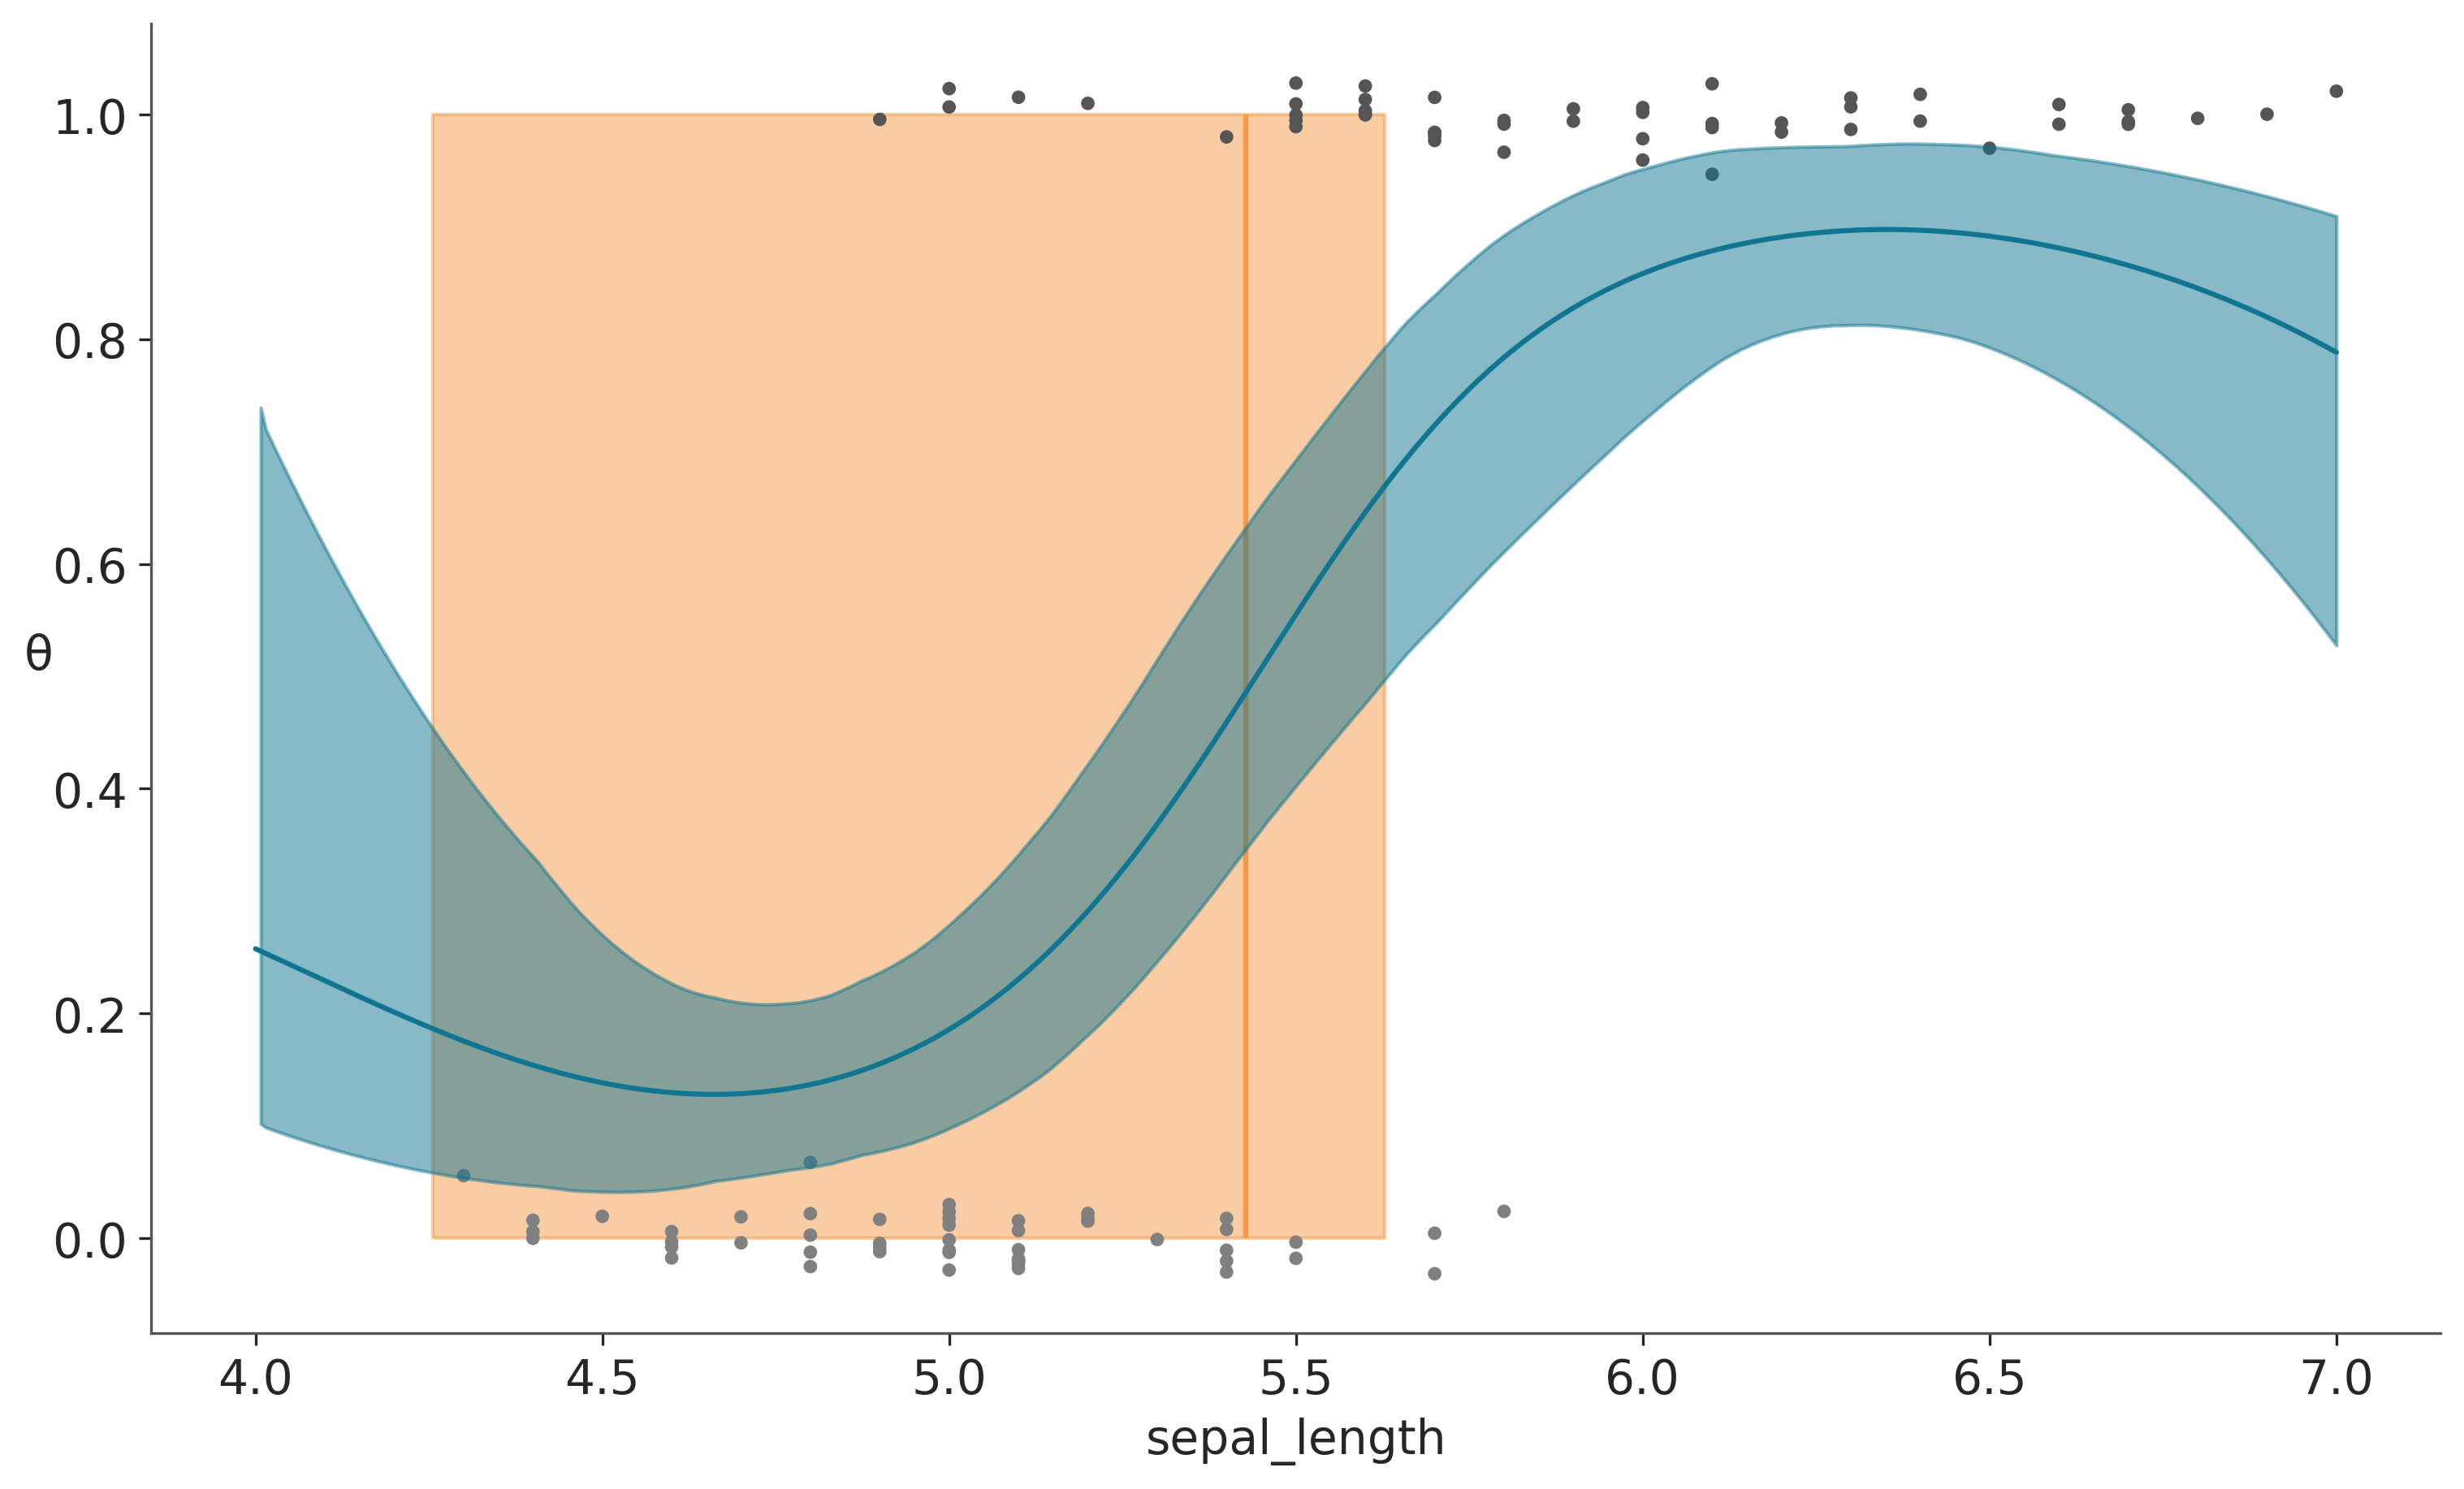

In [26]:
#| code-fold: true

_, ax = plt.subplots(figsize=(10, 6))

fp = logistic(f_pred_iris)
fp_mean = np.mean(fp, 1)

ax.plot(X_new[:, 0], fp_mean)
ax.scatter(x_1, np.random.normal(y, 0.02),
           marker='.', color=[f'{1/(x+2)}' for x in y])

az.plot_hdi(X_new[:, 0], fp.T, color='C0')

decision_boundary = 0.5
db = X_new[:,0][np.argmin(np.abs(fp - decision_boundary), 0)]
db_mean = db.mean()
db_hdi = az.hdi(db)
ax.vlines(db_mean, 0, 1, color='C2', zorder=-1)
ax.fill_betweenx([0, 1], db_hdi[0], db_hdi[1], color='C2', alpha=0.5, zorder=-1)
ax.set_xlabel('sepal_length')
ax.set_ylabel('θ', rotation=0);

Una diferencia con el resultado de la regresión logística es el comportamiento de las colas en la curva sigmoidea, la curva no va hacia 0 para valores bajos de `sepal_length` ni hacia 1 para valores altos. Si nuestra única preocupación es el límite de decisión, entonces el comportamiento en las colas puede ser irrelevante. Pero si queremos modelar las probabilidades de pertenecer a setosa o versicolor en diferentes valores de `sepal_length`, deberíamos hacer algo para mejorar el modelo en las colas.

Un primer paso para solucionar el comportamiento de las colas es entender la razón por la cual sucede. Cuando hay pocos o ningún dato disponible, la distribución a posterior para un GP tenderá a _revertir_ hacia la función a priori. Esto tiene sentido si pensamos que, en ausencia de datos, cualquier distribución a posteriori debería ser esencialmente la distribución a priori.

Una característica que le da mayor versatilidad a los GPs, es que es posible combinar kernel y obtener nuevos comportamientos. A continuación vamos a crear un modelo que combina 3 kernels:

* cuadrático exponencial
* lineal
* ruido blanco

La función del kernel lineal sera hacer que las colas vayan a 0 o 1 en los límites de los datos. La función del kernel de ruido blanco es estabilizar el cálculo de la matriz de covarianza. Agregar un poco de ruido es un truco numérico que ayuda a garantizar que la matriz de covarianza sea válida. De hecho, PyMC internamente utiliza este ruido, pero a veces es necesario agregar un poco más de ruido.

In [27]:
with pm.Model() as model_iris2:
    ℓ = pm.InverseGamma('ℓ', **get_ig_params(x_1))
    c = pm.Normal('c', x_1.min())
    τ = pm.HalfNormal('τ', 5)
    cov = (pm.gp.cov.ExpQuad(1, ℓ) +
           τ * pm.gp.cov.Linear(1, c) +
           pm.gp.cov.WhiteNoise(1E-5))
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior("f", X=X_1)
    # logistic inverse link function and Bernoulli likelihood
    y_ = pm.Bernoulli("y", p=pm.math.sigmoid(f), observed=y)
    idata_iris2 = pm.sample(random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ℓ, c, τ, f_rotated_]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.


In [28]:
with model_iris2:
    f_pred = gp.conditional('f_pred', X_new) 
    idata_iris2_subset = idata_iris2.sel(draw=slice(0, None, 100))
    pred_samples2 = pm.sample_posterior_predictive(idata_iris2_subset,
                                                   var_names=["f_pred"],
                                                   random_seed=123)  


f_pred_iris2 = az.extract(pred_samples2, group="posterior_predictive")['f_pred'].values         

/home/osvaldo/anaconda3/envs/EI2/lib/python3.11/site-packages/pytensor/tensor/rewriting/shape.py:157: UserWarning: Failed to infer_shape from Op Add.
Input shapes: [(TensorConstant(TensorType(int64, shape=()), data=array(100)), TensorConstant(TensorType(int64, shape=()), data=array(100))), (TensorConstant(TensorType(int64, shape=()), data=array(200)), TensorConstant(TensorType(int64, shape=()), data=array(200)))]
Exception encountered during infer_shape: <class 'ValueError'>
Exception message: Could not broadcast dimensions. Incompatible shapes were [(TensorConstant(TensorType(int64, shape=()), data=array(100)), TensorConstant(TensorType(int64, shape=()), data=array(100))), (TensorConstant(TensorType(int64, shape=()), data=array(200)), TensorConstant(TensorType(int64, shape=()), data=array(200)))].
Traceback: Traceback (most recent call last):
  File "/home/osvaldo/anaconda3/envs/EI2/lib/python3.11/site-packages/pytensor/tensor/rewriting/shape.py", line 133, in get_node_infer_shape
   

AssertionError: SpecifyShape: dim 0 of input has shape 100, expected 200.

El resultado lo podemos ver en la siguiente figura:

In [ ]:
_, ax = plt.subplots(figsize=(10, 6))

fp = logistic(f_pred_iris2)
fp_mean = np.mean(fp, 1)

ax.plot(X_new[:, 0], fp_mean)
# plot the data (with some jitter) and the true latent function
ax.scatter(x_1, np.random.normal(y, 0.02),
           marker='.', color=[f'C{x}' for x in y])

az.plot_hdi(X_new[:, 0], fp.T, color='C0')

decision_boundary = 0.5
db = X_new[:,0][np.argmin(np.abs(fp - decision_boundary), 0)]
db_mean = db.mean()
db_hdi = az.hdi(db)
ax.vlines(db_mean, 0, 1, color='C2', zorder=-1)
ax.fill_betweenx([0, 1], db_hdi[0], db_hdi[1], color='C2', alpha=0.5, zorder=-1)
ax.set_xlabel('sepal_length')
ax.set_ylabel('θ', rotation=0)

El ejemplo anterior ilustra que es posible generalizar la aplicación de los GP, de forma similar a los GLMs, pero en la práctica no tiene demasiado sentido utilizar un GP para hacer el trabajo que tranquilamente podemos resolver con una regresión logística. En cambio, queremos utilizar GPs para modelar datos más complejos que no se capturan bien con modelos menos flexibles. Supongamos que queremos modelar la probabilidad de contraer una enfermedad en función de la edad. Resulta que las personas muy jóvenes y muy mayores tienen un riesgo mayor que las personas de mediana edad. El conjunto de datos `gripe_espacial` es un conjunto de datos sintético inspirado en la descripción anterior. La siguiente figura muestra estos datos.

In [ ]:
#| code-fold: true

df_sf = pd.read_csv('datos/gripe_espacial.csv')
age = df_sf.age.values[:, None]
space_flu = df_sf.space_flu

ax = df_sf.plot.scatter('age', 'space_flu', figsize=(8, 5))
ax.set_ylabel("")
ax.set_xlabel("edad")
ax.set_title("Gripe espacial")
ax.set_yticks([0, 1])
ax.set_yticklabels(['sano', 'enfermo']);

In [ ]:
with pm.Model() as modelo_gripe_espacial:
    ℓ = pm.InverseGamma('ℓ', **get_ig_params(age))
    cov = pm.gp.cov.ExpQuad(1, ℓ) + pm.gp.cov.WhiteNoise(1E-5)
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior('f', X=age)
    y_ = pm.Bernoulli('y', p=pm.math.sigmoid(f), observed=space_flu)
    idata_gripe_espacial = pm.sample(random_seed=123)

In [ ]:
X_new = np.linspace(0, 80, 200)[:, None]

    
with modelo_gripe_espacial:
    f_pred = gp.conditional('f_pred', X_new) 
    idata_gripe_espacial_subset = idata_gripe_espacial.sel(draw=slice(0, None, 100))
    pred_samples_gripe = pm.sample_posterior_predictive(idata_gripe_espacial, var_names=["f_pred"],
                                                        random_seed=123)


f_pred_gripe_espacial = az.extract(pred_samples_flu, group="posterior_predictive")['f_pred'].values

Ajustar bien estos datos es imposible para una regresión logística simple, a menos que introduzcamos algunas modificaciones _ad hoc_ para ayudar un poco (ver el ejercicio 6 al final del capítulo para una discusión de dichas modificaciones).

In [ ]:
_, ax = plt.subplots(figsize=(10, 6))

fp = logistic(f_pred_gripe_espacial)
fp_mean = np.nanmean(fp, 1)

ax.scatter(age, np.random.normal(space_flu, 0.02),
           marker='.', color=[f'C{ci}' for ci in space_flu])

ax.plot(X_new[:, 0], fp_mean, 'C2', lw=3)

az.plot_hdi(X_new[:, 0], fp.T, color='C2', smooth=True)
ax.set_yticks([0, 1])
ax.set_yticklabels(['sano', 'enfermo'])
ax.set_xlabel('edad')

## Cox processes

Ahora vamos a modelar datos de conteo. Para ello, utilizaremos la distribución de Poisson como likelihood y la tasa se modelará utilizando un proceso gaussiano. Debido a que la tasa de la distribución de Poisson está limitada a valores positivos, utilizaremos una función exponencial como función de enlace inversa.

En la literatura es común encontrar este tipo de modelos bajo el nombre de proceso de Poisson o proceso de Cox. Un proceso de Poisson es un proceso estocástico donde cada conjunto finito de puntos se distribuye siguiendo una Poisson. Cuando la tasa del proceso de Poisson es en sí misma un proceso estocástico, como, por ejemplo, un proceso gaussiano, entonces tenemos un proceso de Cox.

Para ilustrar este ejemplo usaremos el conjunto de datos de los accidentes mineros que ya vimos anteriormente. Solo que en este caso haremos uso, solamente de una columna de datos, donde cada entrada corresponde con el tiempo (en años) en el que ocurrió cada accidente.

In [ ]:
coal_df = pd.read_csv('datos/coal.csv', header=None)
coal_df.head()

Hemos venido usando GPs para hacer regresión, pero ¿Cómo vamos a realizar una regresión si solo tenemos una única columna de datos?. La respuesta es discretizar los datos, como si estuviéramos construyendo un histograma. Vamos a utilizar los centros de los intervalos como la variable $X$ y los conteos por intervalo como la variable $Y$.

In [ ]:
# discretizamos los datos
years = int((coal_df.max() - coal_df.min()).iloc[0])
bins = years // 4
hist, x_edges = np.histogram(coal_df, bins=bins)
# calculamos la ubicación de los centros de los datos discretizados
x_centers = x_edges[:-1] + (x_edges[1] - x_edges[0]) / 2
# xdata tiene que ser 2D para los GPS
x_data = x_centers[:, None]
y_data = hist

Ahora que tenemos los datos pre-procesados podemos escribir el modelo

In [ ]:
with pm.Model() as modelo_minas:
    ℓ = pm.InverseGamma('ℓ', **get_ig_params(x_edges))
    cov = pm.gp.cov.ExpQuad(1, ls=ℓ) + pm.gp.cov.WhiteNoise(1E-5)
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior('f', X=x_data)

    y_pred = pm.Poisson('y_pred', mu=pm.math.exp(f), observed=y_data)
    idata_minas = pm.sample(random_seed=123)

La siguiente figura muestra la tasa media de desastres en función del tiempo (línea blanca). Las bandas describen el HDI del 50% (más oscuro) y el del 94% (más claro). En la parte inferior, los marcadores negros indican el momento de cada accidente. Como podemos ver, la tasa de accidentes disminuye con el tiempo, a excepción de un breve aumento inicial. 

In [ ]:
_, ax = plt.subplots(figsize=(11, 5))

f_trace = np.exp(idata_minas.posterior['f'].stack(samples=("chain", "draw")).T) / 4
rate_median = np.median(f_trace, axis=0)

ax.plot(x_centers, rate_median, 'w', lw=3)
az.plot_hdi(x_centers, f_trace)

az.plot_hdi(x_centers, f_trace, hdi_prob=0.5,
            plot_kwargs={'alpha': 0})

ax.plot(coal_df, np.zeros_like(coal_df)-0.5, 'k|')
ax.set_xlabel('años')
ax.set_ylabel('tasa');

## Regresión con autocorrelación espacial

El siguiente ejemplo es una modificación de un ejemplo discutido en _Statistical Rethinking_.

Para este ejemplo, tenemos 10 sociedades insulares diferentes; para cada una de ellas, tenemos la cantidad de herramientas que utilizan. Algunas teorías predicen que las poblaciones más grandes desarrollan y mantienen más herramientas que las poblaciones más pequeñas. Por lo tanto, podemos pensar un problema de regresión donde la variable dependiente es la cantidad de herramientas y la variable independiente es la población. Como el número de herramientas es una variable de conteo, podemos utilizar una distribución de Poisson. Además, tenemos buenas razones teóricas para pensar que el logaritmo de la población es una mejor variable que el tamaño absoluto porque lo que realmente importa (según la teoría) es el orden de magnitud de la población.

Hasta ahora, el modelo que tenemos en mente es una regresión de Poisson, pero aquí viene la parte interesante. Otro factor importante que afecta al número de herramientas son las tasas de contacto entre las sociedades insulares. Una forma de incluir la tasa de contacto en nuestro modelo es recopilar información sobre la frecuencia con la que estas sociedades estuvieron en contacto a lo largo de la historia y crear una variable categórica como tasa baja/alta. Pero obtener dicha información no es una tarea sencilla. Una alternativa es utilizar la distancia entre islas como un indicador de la tasa de contacto, ya que es razonable suponer que las sociedades geográficamente cercanas entran en contacto con más frecuencia que las distantes.

La cantidad de herramientas, el tamaño de la población y las coordenadas se almacenan en el archivo `islands.csv`

Omitiendo priors, el modelo que vamos a construir es:

$$
\begin{align*}
    f &\sim \mathcal{GP}([0, \dots, 0], \kappa(X, X')) \\
    \mu &\sim \exp(\alpha + \beta X + f) \\
    Y &= \text{Pois}(\mu)
\end{align*}
$$

Este modelo es un modelo lineal más un término GP. Usamos la parte lineal para modelar el efecto del logaritmo de la población y el término GP para modelar el efecto del contacto entre sociedades. Es decir modelaremos el número de herramientas en cada sociedad como una función de su distribución espacial.

La información sobre la distribución espacial está en términos de latitudes y longitudes, pero los kernels en PyMC suponen que las distancias son todas euclídias. Por lo que vamos a tener que crear un nuevo kernel con una distancia más adecuada.

La distancia de Haversine determina la distancia del círculo máximo entre dos puntos en una esfera dadas sus longitudes y latitudes. La distancia del círculo máximo es la distancia más corta entre dos puntos en la superficie de una esfera medida a lo largo de la superficie de la esfera.

In [ ]:
islands = pd.read_csv('datos/islands.csv')
islands.head().round(1)
X = islands[["lat", "lon"]].values

In [ ]:
class ExpQuadHaversine(pm.gp.cov.Stationary):
    def __init__(self, input_dims, ls, ls_inv=None, r=6.371, active_dims=None):
        super().__init__(input_dims, ls=ls,  ls_inv=ls_inv, active_dims=active_dims)
        self.r = r # earth radius in thousands of km

    def haversine_distance(self, X):

        lat = np.radians(X[:, 0])
        lon = np.radians(X[:, 1])

        latd = lat[:,None] - lat
        lond = lon[:,None] - lon

        d = pt.cos(lat[:,None]) * pt.cos(lat)
        a = pt.sin(latd / 2)** 2 + d * pt.sin(lond / 2)** 2
        c = 2 * pt.arctan2(pt.sqrt(a), pt.sqrt(1 - a))

        return self.r * c

    def full(self, X, _):
        return pt.exp(-0.5 * self.haversine_distance(X))

In [ ]:
culture_labels = islands.culture.values
index = islands.index.values
log_pop = islands.logpop
total_tools = islands.total_tools
x_data = [islands.lat.values[:, None], islands.lon.values[:, None]]

In [ ]:
with pm.Model() as model_islands:
    η = pm.Exponential('η', 2)
    ℓ = pm.InverseGamma('ℓ', **get_ig_params(islands_dist))
    
    cov = η * ExpQuadHaversine(2, ls=ℓ)
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior('f', X=X)

    α = pm.Normal('α', 0, 5)
    β = pm.Normal('β', 0, 1)
    μ = pm.math.exp(α + β * log_pop + f)
    _ = pm.Poisson('tt_pred', μ, observed=total_tools)
    idata_islands = pm.sample(target_accept=0.9, random_seed=123)

In [ ]:
az.summary(idata_islands, var_names=['η', 'ℓ', 'α', 'β'])

Para entender la distribución posterior de las funciones de covarianza en términos de distancias, podemos representar gráficamente algunas muestras de la distribución posterior como en siguiente figura. La curva azul más oscura representa la covarianza mediana posterior en cada distancia y las curvas más claras y finas muestran funciones de la distribución posterior conjunta de $\ell$ y $\eta$.

Usamos la mediana porque las distribuciones para $\ell$ y $\eta$ están muy sesgadas. Podemos ver que la covarianza, en promedio, no es tan alta y también cae a casi 0 a unos 3000 kilómetros. Las líneas delgadas representan la incertidumbre, y podemos ver que hay mucha incertidumbre.

In [ ]:
posterior_islands = idata_islands.posterior.stack(samples=("chain", "draw"))
trace_η = posterior_islands['η'].values
trace_ℓ = posterior_islands['ℓ'].values

_, ax = plt.subplots(1, 1, figsize=(11, 4))
xrange = np.linspace(0, 7)

median_ = np.median(trace_η[:,None] * (np.exp(-xrange**2 / (2*trace_ℓ[:,None]**2))), axis=0)

ax.plot(xrange, median_, lw=3)


ax.plot(xrange, (trace_η[::20][:, None] * np.exp(-xrange**2 / (2*trace_ℓ[::20][:, None]**2))).T,
        'C0', alpha=.1)

ax.set_ylim(0, 1)
ax.set_xlabel('distance (thousand kilometers)')
ax.set_ylabel('covariance');

Ahora veamos qué tan fuertemente correlacionadas están las sociedades insulares según el modelo y los datos. Para ello, tenemos que convertir la matriz de covarianza en una matriz de correlación. 

In [ ]:
# compute posterior median covariance among societies
Σ = np.median(trace_η) * (np.exp(-(islands_dist)**2 / (2*np.median(trace_ℓ)**2)))


# convert to correlation matrix
Σ_post = np.diag(np.diag(Σ)**-0.5)
ρ = Σ_post @  Σ @ Σ_post
ρ = pd.DataFrame(ρ, index=culture_labels, columns=culture_labels)

La siguiente figura muestra un mapa de calor de la matriz de correlación media.

Dos observaciones destacan del resto: en primer lugar Hawái es una isla muy solitaria. Esto tiene sentido, ya que Hawái está muy lejos del resto de sociedades insulares. Además, podemos ver que Malekula (Ml), Tikopia (Ti) y Santa Cruz (SC) están altamente correlacionadas entre sí. Esto también tiene sentido, ya que estas sociedades están muy próximas entre sí y también tienen una cantidad similar de herramientas.

In [ ]:
fig, ax = plt.subplots(figsize=(4.5, 4.5))
ax.imshow(ρ, cmap='viridis_r')

ticks_loc = np.arange(10)
ax.set_xticks(ticks_loc)
ax.set_yticks(ticks_loc)
ax.set_xticklabels(culture_labels, rotation=70)
ax.set_yticklabels(culture_labels);

El panel izquierdo de la siguiente figura es esencialmente un mapa. Las sociedades insulares están representadas por sus posiciones relativas. Las líneas son las correlaciones medianas posteriores entre sociedades. La opacidad de las líneas es proporcional al valor de las correlaciones. En el panel derecho tenemos nuevamente las correlaciones medianas posteriores, pero esta vez graficadas en términos del logaritmo de la población versus el número total de herramientas. Las líneas discontinuas representan el número mediano de herramientas y el HDI del 94\% como función del logaritmo de la población. En ambos paneles de la Figura \ref{fig:GP_islands_spatial}, el tamaño de los puntos es proporcional a la población de cada sociedad insular. Observe cómo las correlaciones entre Malekula, Tikopia y Santa Cruz describen el hecho de que tienen un número bastante bajo de herramientas cercano a la mediana o inferior al número esperado de herramientas para sus poblaciones. Algo similar está sucediendo con Trobriand y Manus; están geográficamente cerca y tienen menos herramientas de lo esperado para el tamaño de sus poblaciones. Tonga tiene muchas más herramientas de lo esperado para su población y una correlación relativamente alta con Fiji. En cierto modo, el modelo nos dice que Tonga tiene un efecto positivo en Lua Fiji, aumentando el número total de herramientas y contrarrestando su efecto sobre sus vecinos cercanos, Malekula, Tikopia y Santa Cruz.

In [ ]:
# scale point size to logpop
logpop = np.copy(log_pop)
logpop /= logpop.max()
psize = np.exp(logpop*5.5)
log_pop_seq = np.linspace(6, 14, 100)
lambda_post = np.exp(posterior_islands['α'].values[:, None] +
                     posterior_islands['β'].values[:, None] * log_pop_seq)

_, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].scatter(islands.lon, islands.lat, psize, zorder=3)
ax[1].scatter(islands.logpop, islands.total_tools, psize, zorder=3)

for i, itext in enumerate(culture_labels):
    ax[0].text(islands.lon[i]+1, islands.lat[i]+1, itext)
    ax[1].text(islands.logpop[i]+.1, islands.total_tools[i]-2.5, itext)


ax[1].plot(log_pop_seq, np.median(lambda_post, axis=0), 'k--')

az.plot_hdi(log_pop_seq, lambda_post,
            hdi_prob=0.8,
            fill_kwargs={'alpha':0},
            plot_kwargs={'color':'k', 'ls':'--', 'alpha':1})


for i in range(10):
    for j in np.arange(i+1, 10):
        ax[0].plot((islands.lon[i], islands.lon[j]),
                   (islands.lat[i], islands.lat[j]), 'C1-',
                   alpha=ρ.iloc[i, j]**2, lw=4)
        ax[1].plot((islands.logpop[i], islands.logpop[j]),
                   (islands.total_tools[i], islands.total_tools[j]), 'C1-',
                   alpha=ρ.iloc[i, j]**2, lw=4)
ax[0].set_xlabel('longitud')
ax[0].set_ylabel('latitud')


ax[1].set_xlabel('log-población')
ax[1].set_ylabel('total herramientas')
ax[1].set_xlim(6.8, 12.8)
ax[1].set_ylim(10, 73)

## HSGPs

Los procesos gaussianos pueden ser lentos. La razón principal es que su cálculo requiere que invirtamos una matriz, cuyo tamaño aumenta con el número de observaciones. En la práctica no se invirte la matriz, si no que se usa una operación más estable numéricamente, llamada descomposición de Cholesky. Pero ambas operaciones escalan con el cubo de los datos, $\mathcal{O}(n^3)$. Es decir son operaciones costosas que no escalan bien con el número de observaciones. Por esa razón, una gran parte de la investigación en torno a los procesos gaussianos se ha centrado en encontrar aproximaciones para calcularlos más rápido y permitir escalarlos a datasets de gran tamaño.

En este casos vamos a utilizar solo una de esas aproximaciones, llamada Proceso Gaussiano en Espacios de Hilbert (HSGP por su sigla en inglés). Los detalles de esta aproximación exceden la discusión de este curso. Pero conceptualmente podemos decir que un espacio de Hilbert es una generalización del espacio euclídeo que nos brinda el marco matemático para pensar funciones ("vectores infinitos") y sus distancia, ángulos etc. En este espacio es posible definir una serie de funciones base que sean ortogonales entre si. Un kernel es aproximado como una serie infinita de estas funciones bases. En la práctica esta serie se trunca. En espíritu estamos haciendo algo similar a como se construyen splines, solo que con otro tipo de función base. 

El resultado práctico es que obtenemos un aproximación que escala como $\mathcal{O}(mn + m)$ para $m$ bases. Una limitación es que solo podemos usar HSGP para dimensiones bajas. En general 1 o 2, quizá 3, y solo para algunos kernels como el cuadrático exponencial o Matern, ya que para estos es posible encontrar las funciones base.

Usar la aproximación HSGP en PyMC es sencillo, como demostraremos con el conjunto de datos de bicicletas. Queremos modelar la cantidad de bicicletas alquiladas como una función de la hora del día en horas. El siguiente bloque de código muestra la implementación de PyMC de dicho modelo.\\

In [ ]:
bikes = pd.read_csv("datos/bikes.csv")
y = bikes["rented"].values
X = bikes["hour"].values[:,None]

In [ ]:
with pm.Model() as model_hsgp:
    ℓ = pm.InverseGamma('ℓ', **get_ig_params(X))

    cov = pm.gp.cov.ExpQuad(1, ls=ℓ)
    gp = pm.gp.HSGP(m=[10], c=1.5, cov_func=cov)

    f = gp.prior('f', X=X)
    α = pm.HalfNormal('α', 1)
    _ = pm.NegativeBinomial("obs", np.exp(f), α, observed=y)

    idata_hsgp = pm.sample(random_seed=123)

La principal diferencia con los modelos GP anteriores es el uso de la clase `pm.gp.HSGP(.)`. Para instanciar esta clase necesitamos definir dos parámetros:

* `m` es el número de funciones base que usamos para aproximar el GP. Cuanto mayor sea el valor de `m` mejor será la aproximación y más costoso el cálculo.
* `c` es un factor de límite. Para un valor fijo y suficientemente grande de `m`, `c` afecta la aproximación de la función media principalmente cerca de los límites. No debe ser menor que 1,2 (PyMC le dará una advertencia si usa un valor menor que este), y generalmente 1,5 es una buena opción. Cambiar este parámetro no afecta la velocidad de los cálculos.

Establecemos `m=10` en parte porque somos fanáticos del sistema decimal y en parte basándonos en las recomendaciones del artículo [Practical Hilbert space approximate...](https://arxiv.org/abs/2004.11408). En la práctica, los resultados son robustos a los valores exactos de `m` y `c`, siempre que se encuentren dentro de cierto rango que depende del prior de la longitud de escala.

Ahora veamos los resultados.

In [ ]:
az.summary(idata_hsgp, var_names=["ℓ", "α"])

In [ ]:
az.plot_trace(idata_hsgp, var_names=["ℓ", "α"]);

La siguiente figura muestra el GP posterior medio en azul oscuro y 100 muestras (realizaciones) del GP posterior (líneas turquesas). Puedes comparar estos resultados con los obtenidos usando splines.

In [ ]:
_, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.plot(bikes["hour"].values, bikes["rented"].values, "C2.")


f = az.extract(idata_hsgp, group="posterior", var_names="f")
idx = np.argsort(X[:,0])
ax.plot(bikes["hour"].values[idx], np.exp(f.values[idx,:100]), alpha=0.25, color="C1")

ax.plot(bikes["hour"].values[idx], np.exp(f.values[idx].mean(1)), color="C0", lw=2);

La aproximación HSGP también está implementada en Bambi. Veamos cómo podemos utilizarla. En principio bastaría hacer

```python
bmb.Model("rented ~ 0 + hsgp(hour, m=10, c=1.5)", bikes, family="negativebinomial")
```

Esto funcionará, pero en general combine definir priors por nuestra cuenta. Esto dará como resultado un muestreo mucho más rápido y muestras más confiables.

Debemos tener en cuenta que los términos HSGP no reciben valores a priori directamente. En su lugar, necesitamos definir valores a priori para $\ell$ (llamado `ell` en Bambi) y $\eta$ (llamado `sigma` en Bambi) y pasar esos valores a priori a los términos HSGP. Una cosa más: en el modelo anterior no usamos $\eta$ pero como Bambi lo espera (ya que es muy común definirlo), usamos un truco bastante barato para definir un valor a priori que sea esencialmente 1.\\

In [ ]:
prior_gp = {
    "sigma": bmb.Prior("Gamma", mu=1, sigma=0.01),
    "ell": bmb.Prior("InverseGamma", **get_ig_params(X)) 
}

priors = {
    "hsgp(hour, m=10, c=1.5)": prior_gp,
    "alpha": bmb.Prior("HalfNormal", sigma=1)
}

model_hsb = bmb.Model("rented ~ 0 + hsgp(hour, m=10, c=1.5)", bikes, family="negativebinomial", priors=priors)
idata_hsb = model_hsb.fit(random_seed=123)

In [ ]:
az.summary(idata_hsb, var_names=["hsgp(hour, m=10, c=1.5)_ell", "rented_alpha"])

In [ ]:
_, ax = bmb.interpret.plot_predictions(model_hsb, idata_hsb, ["hour"],
                                       fig_kwargs={"figsize": (10, 3)})
ax[0].plot(bikes["hour"].values, bikes["rented"].values, "C2.")

## Resumen

Un proceso gaussiano es una generalización de la distribución gaussiana multivariada a infinitas dimensiones y está completamente especificado por una función media y una función de covarianza. Dado que podemos pensar conceptualmente en las funciones como vectores infinitamente largos, podemos utilizar procesos gaussianos como valores a priori sobre el espacio de las funciones. En la práctica, no trabajamos con objetos infinitos sino con distribuciones gaussianas multivariadas con tantas dimensiones como observaciones. Para definir la función de covarianza, utilizamos kernels cuyos parámetros debemos ajustar usando datos; al aprender sobre esos hiperparámetros, terminamos aprendiendo sobre funciones complejas arbitrarias.

En este capítulo, hemos dado una breve introducción a los procesos gaussianos. Hemos discutido como hacer regresión, como integralos en modelos semiparamétricos (el ejemplo de las islas), como combinar dos o más kernels para describir mejor la función desconocida y cómo se puede utilizar un proceso gaussiano para tareas de clasificación. También discutimos una aproximación, HGSP, que permite reducir el costo computacional de los GPs.

GPs es un tema muy extenso con muchas aplicaciones prácticas, pero que suele estar asociado a explicaciones que requieren un alto grado de sofisticación matemática. Espero que esta introducción más práctica los haya motivado lo suficiente para seguir usando, leyendo y aprendiendo sobre los procesos gaussianos.

## Ejercicios

1. Para el ejemplo de la sección \textit{Funciones de covarianza y núcleos}, asegúrese de comprender la relación entre los datos de entrada y la matriz de covarianza generada. Intente utilizar otra entrada como \texttt{data = np.random.normal(size=4)}.

2. Vuelva a ejecutar el código que genera la Figura \ref{fig:dummy_realizations} y aumente la cantidad de muestras obtenidas del GP anterior a alrededor de 200. En la figura original, la cantidad de muestras es 2. ¿Cuál es el rango de los valores generados?

3. Para el gráfico generado en el ejercicio anterior, calcule la desviación estándar para los valores en cada punto. Hazlo de la siguiente forma:
    * Visualmente, simplemente observando los gráficos
    * Directamente a partir de los valores generados a partir de \texttt{pz.MVNormal(.).rvs}
    * Inspeccionando la matriz de covarianza (si tienes dudas, vuelve al ejercicio 1)
    ¿Coincidieron los valores que obtuviste de estos tres métodos?

4. Usa los puntos de prueba \texttt{np.linspace(np.floor(x.min()), 20, 100)[:,None]} y vuelve a ejecutar \texttt{model\_reg}. Grafica los resultados. ¿Qué observaste? ¿Cómo se relaciona esto con la especificación de la prior GP?

5. Repite el ejercicio 1, pero esta vez usa un kernel lineal.

6. Consulta \url{https://www.pymc.io/projects/examples/en/latest/gaussian_processes/GP-MeansAndCovs.html} en la documentación de PyMC.

7. Ejecuta un modelo de regresión logística para los datos de \texttt{space\_flu}. ¿Qué ves? ¿Puedes explicar el resultado?

8. Cambia el modelo de regresión logística para que se ajuste a los datos. Consejo: usa un polinomio de orden 2.

9. Compara el modelo para el desastre de la minería de carbón con el de la documentación de PyMC (\url{https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_overview.html#case-study-2-coal-mining-disasters}). Describe las diferencias entre ambos modelos en términos de especificación del modelo y resultados.